# Prepare preannotated data from GEO

In [24]:
import scanpy as sc
import numpy as np
import pandas as pd
import glob
from scipy.sparse import csr_matrix
import gzip
from tempfile import TemporaryDirectory
import shutil
from scipy import sparse

import matplotlib.pyplot as plt

import mygene

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# %load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
from importlib import reload
reload(h)
import helper as h
from constants import SAVE

In [5]:
ro.r('library("scran")')
ro.r('library("BiocParallel")')

array(['BiocParallel', 'scran', 'SingleCellExperiment',
       'SummarizedExperiment', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'MatrixGenerics', 'matrixStats', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U20')

In [6]:
data_path='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

## GSE83139 - SMART-seq

In [72]:
dataset='GSE83139'
path_ds=data_path+dataset+'/GEO/'

Parse expression data

In [73]:
x=pd.read_table(path_ds+'GSE83139_tbx-v-f-norm-ntv-cpms.csv')

In [74]:
x

,chr,start,end,strand,transcript,part,gene,reads.12730,reads.12731,reads.12732,...,reads.29493,reads.29494,reads.29495,reads.29497,reads.29498,reads.29499,reads.29500,reads.29501,reads.29502,reads.29503
0,chr2,162999385,163008914,*,NM_002054,transcript,GCG,253395.514513,85740.857153,261497.816751,...,18.202805,1.687549,1.507852,2.053468,8.326270,17.281573,12.843336,21.492899,3.642504,2.901910
1,chr11,65265233,65273939,*,NR_002819,transcript,MALAT1,16790.371790,51819.625853,50224.300786,...,35948.073926,30635.371971,51307.333538,3878.062947,7958.793384,47402.517193,56297.844121,79595.937811,39072.274491,65254.565585
2,chr2,79347584,79350545,*,NM_002909,transcript,REG1A,75445.994543,19.392418,11.706527,...,85.930874,18.962315,50.954538,107.087781,85.112034,4685.527761,21.415631,92.341341,64367.570530,54.480117
3,chr17,42018172,42019833,*,NM_002722,transcript,PPY,0.144511,0.164907,6.966857,...,0.189585,0.167512,0.198124,0.164827,0.157381,0.178522,0.178090,0.186311,0.152616,0.192326
4,chr3,187386694,187388201,*,NM_001048,transcript,SST,4.154782,191100.806281,3.273362,...,15.453469,5.081893,119280.734554,10.357633,29.619229,10.736236,15.635378,15.919698,7.482149,37.353222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19945,chr8,136246374,136311962,*,NR_026706,transcript,LOC286094,0.144511,0.164907,0.100256,...,0.189585,0.167512,0.198124,0.164827,0.157381,0.178522,0.178090,0.186311,0.152616,0.192326
19946,chr1,24200460,24239817,*,NM_001841,transcript,CNR2,0.144511,0.164907,0.100256,...,0.189585,0.167512,0.198124,0.164827,0.157381,0.178522,0.178090,0.186311,0.152616,0.192326
19947,chr8,108911544,109095913,*,NM_178565,transcript,RSPO2,0.144511,0.164907,0.100256,...,0.189585,0.167512,0.198124,0.164827,0.157381,0.178522,0.178090,0.186311,0.152616,0.192326
19948,chr11,59210642,59211589,*,NM_001004728,transcript,OR5A1,0.144511,0.164907,0.100256,...,0.189585,0.167512,0.198124,0.164827,0.157381,1.352446,0.178090,0.186311,0.152616,0.192326


In [75]:
# Are gene names unique or are there multiple transcripts per gene?
x.gene.value_counts()

GCG          1
ASPRV1       1
SNN          1
MBD3         1
DIRC3        1
            ..
UVRAG        1
LOC729178    1
NECAB1       1
CDKN1A       1
ASB2         1
Name: gene, Length: 19949, dtype: int64

In [76]:
# Subset to expression only, drop other gene info
x.index=x.gene
x=x[[c for c in x.columns if 'reads.' in c]]
print(x.shape)

(19950, 635)


Load metadata

In [77]:
# metadata
# For some reason there are 2 obs tables on GEO that each contain part of the data
obs1=pd.read_table(path_ds+'GSE83139-GPL16791_series_matrix.txt',
                  skiprows=36,index_col=0)
obs2=pd.read_table(path_ds+'GSE83139-GPL11154_series_matrix.txt',
                  skiprows=36,index_col=0)
obs=pd.concat([obs1,obs2],axis=1)
print(obs.shape)

(47, 635)


In [78]:
obs

,AAJF122 13778,AAJF122 13779,AAJF122 13780,AAJF122 13781,AAJF122 13782,AAJF122 13783,AAJF122 13784,AAJF122 13785,AAJF122 13788,AAJF122 13789,...,ABAF490 16169,ABAF490 16170,ABAF490 16171,ABAF490 16173,ABAF490 16174,ABAF490 16175,ABAF490 16176,ABAF490 16177,ABAF490 16179,ABAF490 16180
!Sample_title,,,,,,,,,,,,,,,,,,,,,
!Sample_geo_accession,GSM2194233,GSM2194234,GSM2194235,GSM2194236,GSM2194237,GSM2194238,GSM2194239,GSM2194240,GSM2194241,GSM2194242,...,GSM2194310,GSM2194311,GSM2194312,GSM2194313,GSM2194314,GSM2194315,GSM2194316,GSM2194317,GSM2194318,GSM2194319
!Sample_status,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,...,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016,Public on Jul 05 2016
!Sample_submission_date,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,...,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016,Jun 08 2016
!Sample_last_update_date,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,...,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020
!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,...,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas
!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
!Sample_characteristics_ch1,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,...,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets,tissue: pancreatic islets


In [79]:
# Subset
obs=obs.loc[['!Sample_characteristics_ch1','!Sample_geo_accession',
         '!Sample_source_name_ch1','!Sample_organism_ch1'],:]

In [80]:
# Edit rownmaes
obs.index=['tissue','age_group','disease','cell_type','geo_accession','organ','organism']
obs.drop('age_group',inplace=True)

In [81]:
# Edit values
for row in ['tissue','disease','cell_type']:
    obs.loc[row,:]=obs.loc[row].apply(lambda x: x.split(': ')[1])
obs.loc['organism']='human'

In [82]:
# Add donor info
obs.loc['donor',:]=[c.split()[0] for c in obs.columns]
donor_df=pd.read_table(path_ds+'GSE83139-meta-Table1.csv',sep=',',index_col=0)
for col in donor_df.columns:
    donor_df[col]=donor_df[col].apply(lambda x:x.rstrip())

In [83]:
# Parse donor info
donor_df['Age']=donor_df['Age'].apply(lambda x:x.split()[0]+' '+x.split()[1][0])
donor_df['Sex']=donor_df['Sex'].str.lower()
donor_df['Ethnicity']=donor_df['Ethnicity'].str.lower()
donor_df['Ethnicity']=donor_df['Ethnicity'].replace(
    {'na':'NA','african american':'african_american'})
donor_df['State']=donor_df['State'].str.rstrip().map(
    {'Control':'healthy','Type 1 diabetes':'T1D','Type 2 diabetes':'T2D','Child':'healthy'})
donor_df.rename({"BMI (kg/m2)":'BMI','Cultured (days)':'cultured_days','State':'disease',
                'Age':'age','Sex':'sex','Ethnicity':'ethnicity'},
                axis=1,inplace=True)
donor_df.index=[r.rstrip() for r in donor_df.index]
donor_df['cultured_days'].astype(float)
donor_df['cultured_days']=donor_df['cultured_days'].astype(float)
donor_df['BMI']=donor_df['BMI'].astype(float)

In [84]:
donor_df

,age,sex,ethnicity,BMI,cultured_days,disease
AAJF122,52 y,male,asian,29.10,6.0,healthy
ABAF490,39 y,female,white,45.20,4.0,healthy
ACAP236,21 y,male,white,39.00,2.0,healthy
ACGI428,23 y,male,NA,25.00,10.0,T1D
HP-15041,57 y,male,african_american,23.98,4.0,T2D
HP-15085,37 y,female,white,39.30,4.0,T2D
HP-15085: cultured,37 y,female,white,39.30,12.0,T2D
ICRH76,2 y,male,white,13.60,2.0,healthy
ICRH80,19 m,female,white,18.00,3.0,healthy


In [85]:
# Check if health matches in donor and cell dfs
obs.T.groupby('donor')['disease'].unique()

donor
AAJF122                   [control]
ABAF490                   [control]
ACAP236                   [control]
ACGI428                       [T1D]
HP-15041                      [T2D]
HP-15085-01T2D::8dcult        [T2D]
HP-15085-01T2D::fresh         [T2D]
ICRH76                    [control]
ICRH80                    [control]
Name: disease, dtype: object

In [86]:
# Rename some donors in obs
obs.loc['donor',:]=obs.loc['donor',:].replace(
    {'HP-15085-01T2D::8dcult':'HP-15085: cultured','HP-15085-01T2D::fresh':'HP-15085'})

In [87]:
# Add donor info to obs
for col in donor_df.columns:
    obs.loc[col,:]=obs.loc['donor',:].map(donor_df[col].to_dict())

In [88]:
# rename obs columns to match x
# Check that removing donor information from cols still produces unique cols
print('Cols unique across donors:',len(set([c.split()[1] for c in  obs.columns]))==obs.shape[1])
obs.columns=['reads.'+c.split()[1] for c in obs.columns]

Cols unique across donors: True


In [89]:
# Cell types
obs.loc['cell_type',:].unique().tolist()

['dropped', 'alpha', 'duct', 'beta', 'pp', 'delta', 'acinar', 'mesenchyme']

In [90]:
# Rename cell types
obs.loc['cell_type_original',:]=obs.loc['cell_type',:]
obs.loc['cell_type',:]=obs.loc['cell_type',:].replace(
    {'duct':'ductal','pp':'gamma'})
obs.loc['cell_type',:].unique().tolist()

['dropped',
 'alpha',
 'ductal',
 'beta',
 'gamma',
 'delta',
 'acinar',
 'mesenchyme']

In [91]:
obs.loc['cell_type',:].value_counts(dropna=False)

alpha         190
dropped       178
beta          111
ductal         96
mesenchyme     27
gamma          18
delta           9
acinar          6
Name: cell_type, dtype: int64

In [92]:
obs

,reads.13778,reads.13779,reads.13780,reads.13781,reads.13782,reads.13783,reads.13784,reads.13785,reads.13788,reads.13789,...,reads.16169,reads.16170,reads.16171,reads.16173,reads.16174,reads.16175,reads.16176,reads.16177,reads.16179,reads.16180
tissue,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,...,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets,pancreatic islets
disease,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,...,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy,healthy
cell_type,dropped,alpha,dropped,alpha,alpha,alpha,dropped,dropped,ductal,dropped,...,beta,dropped,dropped,beta,dropped,dropped,beta,dropped,beta,dropped
geo_accession,GSM2194233,GSM2194234,GSM2194235,GSM2194236,GSM2194237,GSM2194238,GSM2194239,GSM2194240,GSM2194241,GSM2194242,...,GSM2194310,GSM2194311,GSM2194312,GSM2194313,GSM2194314,GSM2194315,GSM2194316,GSM2194317,GSM2194318,GSM2194319
organ,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,...,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas,pancreas
organism,human,human,human,human,human,human,human,human,human,human,...,human,human,human,human,human,human,human,human,human,human
donor,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,...,ABAF490,ABAF490,ABAF490,ABAF490,ABAF490,ABAF490,ABAF490,ABAF490,ABAF490,ABAF490
age,52 y,52 y,52 y,52 y,52 y,52 y,52 y,52 y,52 y,52 y,...,39 y,39 y,39 y,39 y,39 y,39 y,39 y,39 y,39 y,39 y
sex,male,male,male,male,male,male,male,male,male,male,...,female,female,female,female,female,female,female,female,female,female
ethnicity,asian,asian,asian,asian,asian,asian,asian,asian,asian,asian,...,white,white,white,white,white,white,white,white,white,white


In [93]:
obs.T.drop_duplicates('donor')

,tissue,disease,cell_type,geo_accession,organ,organism,donor,age,sex,ethnicity,BMI,cultured_days,cell_type_original
reads.13778,pancreatic islets,healthy,dropped,GSM2194233,pancreas,human,AAJF122,52 y,male,asian,29.1,6.0,dropped
reads.22209,pancreatic islets,healthy,alpha,GSM2194320,pancreas,human,ACAP236,21 y,male,white,39.0,2.0,alpha
reads.22907,pancreatic islets,T2D,delta,GSM2194412,pancreas,human,HP-15041,57 y,male,african_american,23.98,4.0,delta
reads.25937,pancreatic islets,T2D,beta,GSM2194487,pancreas,human,HP-15085,37 y,female,white,39.3,4.0,beta
reads.26031,pancreatic islets,T2D,dropped,GSM2194561,pancreas,human,HP-15085: cultured,37 y,female,white,39.3,12.0,dropped
reads.26086,pancreatic islets,healthy,alpha,GSM2194614,pancreas,human,ICRH76,2 y,male,white,13.6,2.0,alpha
reads.29312,pancreatic islets,healthy,beta,GSM2194662,pancreas,human,ICRH80,19 m,female,white,18.0,3.0,beta
reads.29408,pancreatic islets,T1D,ductal,GSM2194734,pancreas,human,ACGI428,23 y,male,NA,25.0,10.0,duct
reads.16085,pancreatic islets,healthy,dropped,GSM2194246,pancreas,human,ABAF490,39 y,female,white,45.2,4.0,dropped


Make adata

In [94]:
adata=sc.AnnData(X=csr_matrix(x.T),obs=obs.T.reindex(x.T.index),
                 var=pd.DataFrame(index=x.T.columns))

In [95]:
adata

AnnData object with n_obs × n_vars = 635 × 19950
    obs: 'tissue', 'disease', 'cell_type', 'geo_accession', 'organ', 'organism', 'donor', 'age', 'sex', 'ethnicity', 'BMI', 'cultured_days', 'cell_type_original'

In [96]:
adata.obs.cell_type.isna().sum()

0

In [97]:
# Save orginal X
adata.layers['normalised_original']=adata.X.copy()

In [98]:
# Log normalise
sc.pp.log1p(adata)

In [99]:
adata

AnnData object with n_obs × n_vars = 635 × 19950
    obs: 'tissue', 'disease', 'cell_type', 'geo_accession', 'organ', 'organism', 'donor', 'age', 'sex', 'ethnicity', 'BMI', 'cultured_days', 'cell_type_original'
    uns: 'log1p'
    layers: 'normalised_original'

In [100]:
for col in adata.obs.columns:
    print(col)
    print(adata.obs[col].unique())

tissue
['pancreatic islets']
disease
['healthy' 'T2D' 'T1D']
cell_type
['dropped' 'alpha' 'ductal' 'delta' 'beta' 'gamma' 'acinar' 'mesenchyme']
geo_accession
['GSM2194190' 'GSM2194191' 'GSM2194192' 'GSM2194193' 'GSM2194194'
 'GSM2194195' 'GSM2194196' 'GSM2194197' 'GSM2194198' 'GSM2194199'
 'GSM2194200' 'GSM2194201' 'GSM2194202' 'GSM2194203' 'GSM2194204'
 'GSM2194205' 'GSM2194206' 'GSM2194207' 'GSM2194208' 'GSM2194209'
 'GSM2194210' 'GSM2194211' 'GSM2194212' 'GSM2194213' 'GSM2194214'
 'GSM2194215' 'GSM2194216' 'GSM2194217' 'GSM2194218' 'GSM2194219'
 'GSM2194220' 'GSM2194221' 'GSM2194222' 'GSM2194223' 'GSM2194224'
 'GSM2194225' 'GSM2194226' 'GSM2194227' 'GSM2194228' 'GSM2194229'
 'GSM2194230' 'GSM2194231' 'GSM2194232' 'GSM2194233' 'GSM2194234'
 'GSM2194235' 'GSM2194236' 'GSM2194237' 'GSM2194238' 'GSM2194239'
 'GSM2194240' 'GSM2194241' 'GSM2194242' 'GSM2194243' 'GSM2194244'
 'GSM2194245' 'GSM2194246' 'GSM2194247' 'GSM2194248' 'GSM2194249'
 'GSM2194250' 'GSM2194251' 'GSM2194252' 'GSM21942

In [101]:
if SAVE:
    adata.write(path_ds+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'disease' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder

In [102]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds+'adata_filtered.h5ad')

(457, 19950)


## GSE154126 - SMART-seq 

In [103]:
dataset='GSE154126'
path_ds=data_path+dataset+'/GEO/'

Parse expression data

In [104]:
x_norm=pd.read_table(path_ds+'GSE154126_tbx-v-m-b-norm-ntv-cpms.aug.tsv',index_col=0,skiprows=6)
x=pd.read_table(path_ds+'GSE154126_tbx-v-m-b-norm-ntv-reads.aug.tsv',index_col=0,skiprows=6)

In [105]:
x_norm

,cell.12730,cell.12731,cell.12732,cell.12733,cell.12734,cell.12735,cell.12736,cell.12737,cell.12738,cell.12739,...,cell.67791,cell.67792,cell.67793,cell.67795,cell.67796,cell.67797,cell.67798,cell.67799,cell.67800,cell.67801
gene|cell_id,,,,,,,,,,,,,,,,,,,,,
GCG,234710.102092,139577.403174,479111.185854,406288.554849,92.742665,239405.166409,111.953428,1.702976e+06,94.141210,408420.166540,...,919657.823237,425684.833757,712140.381278,107.809229,2031.785733,1885.327801,690100.842339,1469.922844,1268.588369,444.857753
MALAT1,15557.780875,38893.697477,41119.798460,25637.103692,51024.058247,115874.486989,36307.964729,9.297796e+04,47555.242229,94841.564276,...,84289.551238,47730.201381,53360.768287,95901.980216,55893.558315,25978.592439,105115.306844,61049.381712,8582.851032,50344.774003
REG1A,69948.439899,16.735591,17.987454,869.512194,416859.845064,230.176828,626.202394,4.564597e+00,268.891857,33839.141465,...,5.764465,0.163108,2.274921,1.278053,0.172764,0.160323,0.170293,9.396887,5.562781,30.991186
IAPP,1.977654,1.194333,43.382359,0.175120,0.127207,0.169774,6.249202,3.427550e+00,2.561342,4.951575,...,9.046570,3.981550,4.052427,18.013484,87867.647947,49.799282,2.365756,16.591597,5.015328,0.172722
PRSS1,10768.324618,0.906236,0.863041,6.391795,26651.898859,417.437341,1.068870,6.579922e+00,1.416327,7579.338200,...,1.633766,0.163108,0.713754,0.155407,0.172764,363.655572,0.170293,0.157423,5660.714604,2.015413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC100192378,0.133999,0.150800,0.097562,0.175120,0.127207,0.169774,0.150991,1.465047e-01,0.127835,0.111404,...,0.170634,0.163108,0.173656,0.155407,0.172764,0.160323,0.170293,0.157423,0.167251,0.172722
RNF224,0.133999,0.150800,0.097562,0.175120,0.127207,0.169774,0.150991,1.465047e-01,0.127835,0.111404,...,0.170634,0.163108,0.173656,0.155407,0.172764,0.160323,0.170293,0.157423,0.167251,0.172722
LOC200261,0.133999,0.150800,0.097562,0.175120,0.127207,0.169774,0.150991,1.465047e-01,0.127835,0.111404,...,0.170634,0.163108,0.173656,0.155407,0.172764,0.160323,0.170293,0.157423,0.167251,0.172722


In [106]:
x

,cell.12730,cell.12731,cell.12732,cell.12733,cell.12734,cell.12735,cell.12736,cell.12737,cell.12738,cell.12739,...,cell.67791,cell.67792,cell.67793,cell.67795,cell.67796,cell.67797,cell.67798,cell.67799,cell.67800,cell.67801
gene|cell_id,,,,,,,,,,,,,,,,,,,,,
GCG,568123,155107,1131756,333594,158,769509,283,1798891,232,481576,...,1493923,959437,1264341,130,1046,1376,1619197,1061,363,631
MALAT1,34144,70753,152425,38615,98461,65818,68077,84386,121287,109390,...,90766,113501,130946,68302,56957,30939,83570,65939,9398,49946
REG1A,208991,34,45,744,636458,556,1543,3,242,59471,...,2,0,4,1,0,0,0,10,5,54
IAPP,3,2,138,0,0,0,14,4,6,8,...,12,10,10,24,59525,12,1,16,6,0
PRSS1,31894,3,4,5,45068,1011,1,2,1,10345,...,1,0,1,0,0,294,0,0,6217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC100192378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RNF224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC200261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
x.columns=[c.replace('cell.','') for c in x.columns]

In [108]:
print('Some gene names have no name:',x.index.isna().sum())

Some gene names have no name: 1


In [109]:
# Subset with genes with names
x=x[~x.index.isna()]
x_norm=x_norm[~x_norm.index.isna()]

Obs

In [110]:
# Some obs data also in expression table
obs_x1=pd.read_table(path_ds+'GSE154126_tbx-v-m-b-norm-ntv-cpms.aug.tsv',index_col=0,nrows=6)
obs_x2=pd.read_table(path_ds+'GSE154126_tbx-v-m-b-norm-ntv-reads.aug.tsv',index_col=0,nrows=6)
print('Both obs datasets in X files are the same:',(obs_x1==obs_x2).all().all())

Both obs datasets in X files are the same: True


In [111]:
obs_x1

,AAJF122,AAJF122.1,AAJF122.2,AAJF122.3,AAJF122.4,AAJF122.5,AAJF122.6,AAJF122.7,AAJF122.8,AAJF122.9,...,AEHL151.29,AEHL151.30,AEHL151.31,AEHL151.32,AEHL151.33,AEHL151.34,AEHL151.35,AEHL151.36,AEHL151.37,AEHL151.38
source_id,,,,,,,,,,,,,,,,,,,,,
condition_health_status,Control,Control,Control,Control,Control,Control,Control,Control,Control,Control,...,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D
condition_age_group,Adult,Adult,Adult,Adult,Adult,Adult,Adult,Adult,Adult,Adult,...,Adult,Adult,Adult,Adult,Adult,Adult,Adult,Adult,Adult,Adult
donor_gender,male,male,male,male,male,male,male,male,male,male,...,male,male,male,male,male,male,male,male,male,male
CellType,dropped,dropped,dropped,alpha,acinar,dropped,duct,alpha,duct,dropped,...,alpha,alpha,alpha,dropped,beta,duct,alpha,dropped,dropped,mesenchyme
ppr_kkdt_condition,age-4-adult,age-4-adult,age-4-adult,age-4-adult,age-4-adult,age-4-adult,age-4-adult,age-4-adult,age-4-adult,age-4-adult,...,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D
gene|cell_id,cell.12730,cell.12731,cell.12732,cell.12733,cell.12734,cell.12735,cell.12736,cell.12737,cell.12738,cell.12739,...,cell.67791,cell.67792,cell.67793,cell.67795,cell.67796,cell.67797,cell.67798,cell.67799,cell.67800,cell.67801


In [112]:
# metadata
# For some reason there are 2 obs tables on GEO that each contain part of the data
obs1=pd.read_table(path_ds+'GSE154126-GPL11154_series_matrix.txt',
                  skiprows=38,index_col=0)
obs2=pd.read_table(path_ds+'GSE154126-GPL16791_series_matrix.txt',
                  skiprows=38,index_col=0)
obs=pd.concat([obs1,obs2],axis=1)
print(obs.shape)

(47, 1263)


In [113]:
# Correct col names to remove donor info from cell names as it is already in the table, 
# for x matching
obs.columns=[c.split(':')[0] for c in obs.columns]

In [114]:
obs

,12730,12731,12732,12733,12734,12735,12736,12737,12738,12739,...,67791,67792,67793,67795,67796,67797,67798,67799,67800,67801
!Sample_title,,,,,,,,,,,,,,,,,,,,,
!Sample_geo_accession,GSM4812428,GSM4812429,GSM4812430,GSM4812431,GSM4812432,GSM4812433,GSM4812434,GSM4812435,GSM4812436,GSM4812437,...,GSM4813681,GSM4813682,GSM4813683,GSM4813684,GSM4813685,GSM4813686,GSM4813687,GSM4813688,GSM4813689,GSM4813690
!Sample_status,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,...,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020,Public on Oct 01 2020
!Sample_submission_date,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,...,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020,Oct 01 2020
!Sample_last_update_date,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,...,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020,Oct 06 2020
!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,AAJF122,...,AEHL151,AEHL151,AEHL151,AEHL151,AEHL151,AEHL151,AEHL151,AEHL151,AEHL151,AEHL151
!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
!Sample_characteristics_ch1,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,...,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas,tissue: pancreas


In [115]:
# Select columns
obs=obs.T[['!Sample_geo_accession']]
obs.columns=['geo_accession']

In [116]:
# Check if some cells from x are missing in obs
[c for c in x.columns if c not in obs.index]

['12766',
 '13786',
 '13787',
 '16122',
 '16168',
 '25996',
 '26000',
 '26001',
 '26002',
 '26003',
 '26004',
 '26005',
 '26006']

In [117]:
# Concat both obs datasets
# Format col names
obs_x1.loc['source_id',:]=obs_x1.columns
obs_x1.columns=obs_x1.loc['gene|cell_id',:].str.replace('cell.','',regex=False)
obs_x1=obs_x1.T.rename({'source_id':'donor'})
obs=pd.concat([obs,obs_x1],axis=1)

In [118]:
obs

,geo_accession,condition_health_status,condition_age_group,donor_gender,CellType,ppr_kkdt_condition,gene|cell_id,source_id
12730,GSM4812428,Control,Adult,male,dropped,age-4-adult,cell.12730,AAJF122
12731,GSM4812429,Control,Adult,male,dropped,age-4-adult,cell.12731,AAJF122.1
12732,GSM4812430,Control,Adult,male,dropped,age-4-adult,cell.12732,AAJF122.2
12733,GSM4812431,Control,Adult,male,alpha,age-4-adult,cell.12733,AAJF122.3
12734,GSM4812432,Control,Adult,male,acinar,age-4-adult,cell.12734,AAJF122.4
...,...,...,...,...,...,...,...,...
26002,NaN,T2D,Adult,female,dropped,T2D,cell.26002,HP-15085-01T2D.55
26003,NaN,T2D,Adult,female,dropped,T2D,cell.26003,HP-15085-01T2D.56
26004,NaN,T2D,Adult,female,dropped,T2D,cell.26004,HP-15085-01T2D.57
26005,NaN,T2D,Adult,female,dropped,T2D,cell.26005,HP-15085-01T2D.58


C: Some cells miss geo_accession, but that not supplied as matrix series has less cells than expresion matrix

In [119]:
# Parse obs
# Select only some cols as others in donor df
obs=obs[['geo_accession','condition_health_status','CellType','source_id']]
obs.rename({'condition_health_status':'disease','CellType':'cell_type_original',
           'source_id':'donor'},axis=1,inplace=True)
obs['disease']=obs['disease'].replace({'Control':'healthy'})

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-119-6ad7e6254df3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['disease']=obs['disease'].replace({'Control':'healthy'})


In [120]:
# Parse donors
obs['donor']=obs.donor.apply(lambda x: x.split('.')[0])

<ipython-input-120-d52703d52411>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['donor']=obs.donor.apply(lambda x: x.split('.')[0])


Add donor info

In [121]:
# Load donor info
donor_df=pd.read_excel(path_ds+'GSE154126_donors.xlsx',index_col=0).iloc[:-1,:]

In [122]:
donor_df

,Age,Gender,Ethnicity,BMI,Condition
Donor ID,,,,,
ICRH85,18d,female,Hispanic,19.5,Newborn
ACJW006,10m,male,African.American,19.5,Toddler
HPAP011,3y,male,African.American,17.6,Toddler
ICRH76,2y,male,European.American,13.6,Toddler *
ICRH80,19m,female,European.American,18,Toddler *
ICRH97,4y,male,European.American,15.1,Toddler
ADEY348,11y,male,European.American,17.8,Adolescent
ADFY260,12y,female,African.American,23.26,Adolescent
AAJF122,52y,male,Asian.American,29.1,Adult *


In [123]:
# Parse donor df
donor_df.drop('Condition',axis=1,inplace=True) # Drop as better in other table
donor_df.rename(
    {'Age':'age','Gender':'sex','Ethnicity':'ethnicity','BMI':'BMI',
                 'Condition':'disease'},axis=1,inplace=True)
donor_df['age']=donor_df['age'].apply(lambda x: x[:-1]+' '+x[-1])
donor_df['ethnicity']=donor_df['ethnicity'
                              ].str.lower().str.replace('.','_').replace({'NA':np.nan})
donor_df.replace('NA',np.nan)

<ipython-input-123-f5c5489e21de>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  donor_df['ethnicity']=donor_df['ethnicity'


,age,sex,ethnicity,BMI
Donor ID,,,,
ICRH85,18 d,female,hispanic,19.5
ACJW006,10 m,male,african_american,19.5
HPAP011,3 y,male,african_american,17.6
ICRH76,2 y,male,european_american,13.6
ICRH80,19 m,female,european_american,18
ICRH97,4 y,male,european_american,15.1
ADEY348,11 y,male,european_american,17.8
ADFY260,12 y,female,african_american,23.26
AAJF122,52 y,male,asian_american,29.1


In [124]:
donor_df=donor_df.replace('\xa0NA',np.nan).replace('\xa0na',np.nan)

In [125]:
donor_df

,age,sex,ethnicity,BMI
Donor ID,,,,
ICRH85,18 d,female,hispanic,19.50
ACJW006,10 m,male,african_american,19.50
HPAP011,3 y,male,african_american,17.60
ICRH76,2 y,male,european_american,13.60
ICRH80,19 m,female,european_american,18.00
ICRH97,4 y,male,european_american,15.10
ADEY348,11 y,male,european_american,17.80
ADFY260,12 y,female,african_american,23.26
AAJF122,52 y,male,asian_american,29.10


In [126]:
# Add donor to obs
for col in donor_df.columns:
    obs[col]=obs['donor'].map(donor_df[col].to_dict())

<ipython-input-126-838746911d5a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs[col]=obs['donor'].map(donor_df[col].to_dict())


In [127]:
obs.cell_type_original.value_counts()

dropped       651
alpha         234
beta          182
duct          100
mesenchyme     44
acinar         30
pp             19
delta          10
masked          6
Name: cell_type_original, dtype: int64

In [128]:
obs['cell_type']=obs['cell_type_original'].replace({
    'duct':'ductal','pp':'gamma','masked':'dropped'})
obs.cell_type.value_counts(dropna=False)

dropped       657
alpha         234
beta          182
ductal        100
mesenchyme     44
acinar         30
gamma          19
delta          10
Name: cell_type, dtype: int64

In [129]:
# Check donors
obs.drop_duplicates('donor')

,geo_accession,disease,cell_type_original,donor,age,sex,ethnicity,BMI,cell_type
12730,GSM4812428,healthy,dropped,AAJF122,52 y,male,asian_american,29.10,dropped
16085,GSM4812484,healthy,dropped,ABAF490,39 y,female,european_american,45.20,dropped
22209,GSM4812568,healthy,alpha,ACAP236,21 y,male,european_american,39.00,alpha
22907,GSM4812660,T2D,dropped,HP-15041,57 y,male,african_american,23.98,dropped
25937,GSM4812739,T2D,beta,HP-15085-01T2D,37 y,female,european_american,39.30,beta
26086,GSM4812867,healthy,dropped,ICRH76,2 y,male,european_american,13.60,dropped
29312,GSM4812916,healthy,dropped,ICRH80,19 m,female,european_american,18.00,dropped
39683,GSM4812992,T2D,dropped,HP15269-01T2D,55 y,female,european_american,29.84,dropped
39718,GSM4813015,healthy,dropped,ACJW006,10 m,male,african_american,19.50,dropped
39765,GSM4813057,healthy,dropped,ACHL274,61 y,male,hispanic,26.80,dropped


Make adata

In [130]:
# Check that x and x_norm match
if not (x.index==x_norm.index).all() and \
    (x.columns==[c.replace('cell.','') for c in x_norm.columns]).all():
    raise ValueError('x and x_norm not matching')

In [131]:
adata=sc.AnnData(X=csr_matrix(x.T),obs=obs.reindex(x.T.index),
                layers={'normalised_original':csr_matrix(x_norm.T)},
                 var=pd.DataFrame(index=x.T.columns))

In [132]:
adata

AnnData object with n_obs × n_vars = 1276 × 21152
    obs: 'geo_accession', 'disease', 'cell_type_original', 'donor', 'age', 'sex', 'ethnicity', 'BMI', 'cell_type'
    layers: 'normalised_original'

In [133]:
# Save orginal X
adata.layers['raw']=adata.X.copy()

In [134]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [135]:
adata

AnnData object with n_obs × n_vars = 1276 × 21152
    obs: 'geo_accession', 'disease', 'cell_type_original', 'donor', 'age', 'sex', 'ethnicity', 'BMI', 'cell_type'
    uns: 'log1p'
    layers: 'normalised_original', 'raw'

In [136]:
for col in adata.obs.columns:
    print(col)
    print(adata.obs[col].unique())

geo_accession
['GSM4812428' 'GSM4812429' 'GSM4812430' ... 'GSM4813688' 'GSM4813689'
 'GSM4813690']
disease
['healthy' 'T2D']
cell_type_original
['dropped' 'alpha' 'acinar' 'duct' 'delta' 'beta' 'pp' 'mesenchyme'
 'masked']
donor
['AAJF122' 'ABAF490' 'ACAP236' 'HP-15041' 'HP-15085-01T2D' 'ICRH76'
 'ICRH80' 'HP15269-01T2D' 'ACJW006' 'ACHL274' 'ACIA085_APT2D' 'ICRH85'
 'HP16012_1T2D' 'ICRH95' 'ADDU206' 'ICRH97' 'ADEY348' 'ADFY260' 'AEBK009'
 'HPAP011' 'AEGY230A' 'AEHL151']
age
['52 y' '39 y' '21 y' '57 y' '37 y' '2 y' '19 m' '55 y' '10 m' '61 y'
 '64 y' '18 d' '42 y' '60 y' '41 y' '4 y' '11 y' '12 y' '53 y' '3 y'
 '59 y']
sex
['male' 'female']
ethnicity
['asian_american' 'european_american' 'african_american' 'hispanic' nan]
BMI
[29.1  45.2  39.   23.98 39.3  13.6  18.   29.84 19.5  26.8  33.16 43.7
 28.2  26.2  15.1  17.8  23.26   nan 17.6  42.8  27.7 ]
cell_type
['dropped' 'alpha' 'acinar' 'ductal' 'delta' 'beta' 'gamma' 'mesenchyme']


In [137]:
if SAVE:
    adata.write(path_ds+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'geo_accession' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'disease' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.

In [138]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds+'adata_filtered.h5ad')

(619, 21152)


## GSE101207 - Drop-seq

In [139]:
dataset='GSE101207'
path_ds=data_path+dataset+'/GEO/'

Parse metadata

In [140]:
sm=pd.read_table(path_ds+'GSE101207-GPL11154_series_matrix.txt',skiprows=34,index_col=0)
sm1=pd.read_table(path_ds+'GSE101207-GPL17021_series_matrix.txt',skiprows=34,index_col=0)
print('SM1 is mouse:',(sm1.loc['!Sample_organism_ch1',:]=='Mus musculus').all())
print('SM shape:',sm.shape)

SM1 is mouse: True
SM shape: (43, 9)


In [141]:
sm

,Dropseq-H1,Dropseq-H2,Dropseq-H3,Dropseq-H4,Dropseq-H5,Dropseq-T2D1,Dropseq-T2D2,Dropseq-H6,Dropseq-T2D3
!Sample_title,,,,,,,,,
!Sample_geo_accession,GSM2700338,GSM2700339,GSM2700340,GSM2700341,GSM2700342,GSM2700343,GSM2700344,GSM2863188,GSM2863189
!Sample_status,Public on Sep 20 2018,Public on Sep 20 2018,Public on Sep 20 2018,Public on Sep 20 2018,Public on Sep 20 2018,Public on Sep 20 2018,Public on Sep 20 2018,Public on Sep 20 2018,Public on Sep 20 2018
!Sample_submission_date,Jul 11 2017,Jul 11 2017,Jul 11 2017,Jul 11 2017,Jul 11 2017,Jul 11 2017,Jul 11 2017,Nov 21 2017,Nov 21 2017
!Sample_last_update_date,Sep 20 2018,Sep 20 2018,Sep 20 2018,Sep 20 2018,Sep 20 2018,Sep 20 2018,Sep 20 2018,Sep 20 2018,Sep 20 2018
!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
!Sample_channel_count,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,Non-diabetic donor 1,Non-diabetic donor 2,Non-diabetic donor 3,Non-diabetic donor 4,Non-diabetic donor 5,Diabetic donor 1,Diabetic donor 2,Non-diabetic donor 6,Diabetic donor 3
!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
!Sample_characteristics_ch1,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet,tissue: Cadaveric pancreatic islet


Series matrix contains only donor info

In [142]:
obs=pd.read_excel(path_ds+'1-s2.0-S2211124719302141-mmc2.xlsx',sheet_name='Celltype.info',
                  skiprows=2,index_col=0)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [143]:
obs

,Tx.all,Tx.D,Donor,celltype
Cell.ID,,,,
AAAAAAAATAGG,880,297.0,H1,allBeta
AAAAAAATAATT_e,580,381.0,H5,Beta
AAAAAACGTCCA_f,281,281.0,H6,Alpha
AAAAAAGTGAAA_d,147,147.0,H4,NaN
AAAAAATCAGAA_e,535,343.0,H5,Alpha
...,...,...,...,...
TTTTTTCTCAGT_d,3017,3017.0,H4,Beta
TTTTTTCTGATC_d,122,122.0,H4,Beta
TTTTTTGAACAA_c,2904,2745.0,H3,Alpha


In [144]:
# Drop unused columns
obs.drop(['Tx.all','Tx.D'],axis=1,inplace=True)
# rename ct col
obs.rename({'celltype':'cell_type','Donor':'donor'},axis=1,inplace=True)

In [145]:
# Cell types
obs['cell_type'].value_counts(dropna=False)

Alpha      14232
NaN        11879
Beta        9965
duct        1283
psc         1142
pp           647
delta        635
Acinar       108
Epsilon       13
allBeta        1
Name: cell_type, dtype: int64

In [146]:
# Parse cts
obs['cell_type']=obs['cell_type'].replace({'allBeta':'Beta'})
obs['cell_type_original']=obs['cell_type']
obs['cell_type']=obs['cell_type'].str.lower().replace({
    'duct':'ductal','psc':'stellate','pp':'gamma'}).fillna('dropped')

In [147]:
obs['cell_type'].value_counts(dropna=False)

alpha       14232
dropped     11879
beta         9966
ductal       1283
stellate     1142
gamma         647
delta         635
acinar        108
epsilon        13
Name: cell_type, dtype: int64

From the paper: "28,026 “clean” cells without ambiguity" - others I have named here as dropped

Find mapping between donor id and cell suffix

In [148]:
donor_suf=set()
for idx,data in obs.iterrows():
    donor_suf.add(tuple([data['donor'],(idx.split('_')[1] if len(idx.split('_'))>1 else None)]))
print(donor_suf)

{('T2D3', 'i'), ('H1', None), ('T2D2', 'h'), ('H2', 'b'), ('H6', 'f'), ('T2D1', 'g'), ('H5', 'e'), ('H4', 'd'), ('H3', 'c')}


In [149]:
# Change suffix to donor to make processing easier downstream when mattching to expression
obs.index=[i.split('_')[0]+'_'+donor for i,donor in zip(obs.index,obs.donor)]

In [150]:
# Donor info
donor_df=pd.read_excel(path_ds+'1-s2.0-S2211124719302141-mmc2.xlsx',sheet_name='Donor_Full_info',
                  skiprows=2,index_col=0)

In [151]:
donor_df

,Gender,Age,BMI,HbA1c,Race,Height,Weight,Death cause,disease status
Sample,,,,,,,,,
H1,M,27,20.60,5.400,Ascian-filipino,NaN,NaN,Stroke,non-diabetic
H2,M,21,22.80,5.200,Caucasian,69.0,154.0,Trauma,non-diabetic
H3,F,38,34.40,5.000,Caucasian,69.0,233.0,Anoxic event,non-diabetic
H4,M,52,22.00,5.600,Caucasian,74.0,173.0,Stroke,non-diabetic
H5,M,28,30.80,4.900,Caucasian,71.0,220.0,Stroke,non-diabetic
H6,M,44,34.60,0.054,Caucasian,60.0,255.0,automobile accident,non-diabetic
T2D1,M,58,39.30,8.900,Caucasian,70.0,274.0,Anoxic event,Type 2 diabetes
T2D2,M,61,28.10,5.200,Caucasian,NaN,NaN,Cerebral Vascular accident,Type 2 diabetes
T2D3,M,51,35.59,0.071,Hispanic,57.0,240.0,stroke,Type 2 diabetes


In [152]:
# Edit colnames and values
donor_df.fillna('NA',inplace=True)
donor_df.drop(['Weight','Height'],axis=1,inplace=True)
donor_df.rename({'Gender':'sex','Age':'age','Race':'ethnicity',
                 'Death cause':'death_cause','disease status':'disease'},axis=1,inplace=True)
donor_df['sex'].replace({'M':'male','F':'female'},inplace=True)
donor_df['age']=donor_df['age'].apply(lambda x: str(x)+' y')
donor_df['ethnicity']=donor_df['ethnicity'].str.lower()
donor_df['death_cause']=donor_df['death_cause'].str.lower()
donor_df['disease'].replace(
    {'non-diabetic':'healthy','Type 2 diabetes':'T2D'},inplace=True)

In [153]:
donor_df

,sex,age,BMI,HbA1c,ethnicity,death_cause,disease
Sample,,,,,,,
H1,male,27 y,20.60,5.400,ascian-filipino,stroke,healthy
H2,male,21 y,22.80,5.200,caucasian,trauma,healthy
H3,female,38 y,34.40,5.000,caucasian,anoxic event,healthy
H4,male,52 y,22.00,5.600,caucasian,stroke,healthy
H5,male,28 y,30.80,4.900,caucasian,stroke,healthy
H6,male,44 y,34.60,0.054,caucasian,automobile accident,healthy
T2D1,male,58 y,39.30,8.900,caucasian,anoxic event,T2D
T2D2,male,61 y,28.10,5.200,caucasian,cerebral vascular accident,T2D
T2D3,male,51 y,35.59,0.071,hispanic,stroke,T2D


In [154]:
# Add donor info to obs
for col in donor_df.columns:
    obs[col]=obs['donor'].map(donor_df[col].to_dict())

In [155]:
obs['organ']='pancreas'
obs['tissue']='pancreatic islets'
obs['organism']='human'

In [156]:
obs

,donor,cell_type,cell_type_original,sex,age,BMI,HbA1c,ethnicity,death_cause,disease,organ,tissue,organism
AAAAAAAATAGG_H1,H1,beta,Beta,male,27 y,20.60,5.400,ascian-filipino,stroke,healthy,pancreas,pancreatic islets,human
AAAAAAATAATT_H5,H5,beta,Beta,male,28 y,30.80,4.900,caucasian,stroke,healthy,pancreas,pancreatic islets,human
AAAAAACGTCCA_H6,H6,alpha,Alpha,male,44 y,34.60,0.054,caucasian,automobile accident,healthy,pancreas,pancreatic islets,human
AAAAAAGTGAAA_H4,H4,dropped,NaN,male,52 y,22.00,5.600,caucasian,stroke,healthy,pancreas,pancreatic islets,human
AAAAAATCAGAA_H5,H5,alpha,Alpha,male,28 y,30.80,4.900,caucasian,stroke,healthy,pancreas,pancreatic islets,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCTCAGT_H4,H4,beta,Beta,male,52 y,22.00,5.600,caucasian,stroke,healthy,pancreas,pancreatic islets,human
TTTTTTCTGATC_H4,H4,beta,Beta,male,52 y,22.00,5.600,caucasian,stroke,healthy,pancreas,pancreatic islets,human
TTTTTTGAACAA_H3,H3,alpha,Alpha,female,38 y,34.40,5.000,caucasian,anoxic event,healthy,pancreas,pancreatic islets,human
TTTTTTTGGACG_T2D3,T2D3,dropped,NaN,male,51 y,35.59,0.071,hispanic,stroke,T2D,pancreas,pancreatic islets,human


In [157]:
obs.drop_duplicates('donor')

,donor,cell_type,cell_type_original,sex,age,BMI,HbA1c,ethnicity,death_cause,disease,organ,tissue,organism
AAAAAAAATAGG_H1,H1,beta,Beta,male,27 y,20.60,5.400,ascian-filipino,stroke,healthy,pancreas,pancreatic islets,human
AAAAAAATAATT_H5,H5,beta,Beta,male,28 y,30.80,4.900,caucasian,stroke,healthy,pancreas,pancreatic islets,human
AAAAAACGTCCA_H6,H6,alpha,Alpha,male,44 y,34.60,0.054,caucasian,automobile accident,healthy,pancreas,pancreatic islets,human
AAAAAAGTGAAA_H4,H4,dropped,NaN,male,52 y,22.00,5.600,caucasian,stroke,healthy,pancreas,pancreatic islets,human
AAAAAATTAAAT_T2D3,T2D3,dropped,NaN,male,51 y,35.59,0.071,hispanic,stroke,T2D,pancreas,pancreatic islets,human
AAAAACGATACC_H3,H3,alpha,Alpha,female,38 y,34.40,5.000,caucasian,anoxic event,healthy,pancreas,pancreatic islets,human
AAAAATCCCTAA_T2D2,T2D2,dropped,NaN,male,61 y,28.10,5.200,caucasian,cerebral vascular accident,T2D,pancreas,pancreatic islets,human
AAAACACAGCAT_H2,H2,dropped,NaN,male,21 y,22.80,5.200,caucasian,trauma,healthy,pancreas,pancreatic islets,human
AAAACTAAGGCA_T2D1,T2D1,gamma,pp,male,58 y,39.30,8.900,caucasian,anoxic event,T2D,pancreas,pancreatic islets,human


Read expression data and convert to sparse adata

In [158]:
adata=[]
for donor in obs.donor.unique():
    files=glob.glob(path_ds+'*_'+donor+'.down.gene_exon_tagged.cleaned.dge.txt')
    if len(files)!=1:
        raise ValueError('Not exactly 1 file per donor')
    x_sub=pd.read_table(files[0], index_col=0).T
    x_sub.index=[i+'_'+donor for i in x_sub.index]
    x_sub=sc.AnnData(x_sub)
    x_sub.X=csr_matrix(x_sub.X)
    adata.append(x_sub)
adata=sc.concat(adata,join='outer')

In [159]:
print('N cells not in obs:',len([o for o in adata.obs_names if o not in obs.index]),
      'N cells in obs:',len([o for o in adata.obs_names if o in obs.index]),
      'N obs cells not in data:',len([o for o in obs.index if o not in adata.obs_names]))
print('Obs cells not in x:')
print([o for o in obs.index if o not in adata.obs_names])

N cells not in obs: 76142 N cells in obs: 39858 N obs cells not in data: 47
Obs cells not in x:
['AACTACACTGGG_T2D2', 'AACTTGAAATTN_H5', 'AAGGCCTACGAT_H2', 'ACCGAGTCATTA_H1', 'ACCTTCACCAGN_H2', 'ACTCCGAATCAT_H2', 'AGACAGACCACN_H3', 'AGAGCATTTTTG_T2D2', 'AGAGCGGAGTTN_H5', 'AGCATTGGTGAN_H3', 'AGCTGGATATTA_H2', 'AGGCAGCTATCN_H1', 'AGGGTTATCTAN_H2', 'ATTTAGTATATN_H2', 'CACGAAAGGCAG_H2', 'CAGCAGCCCAGN_H5', 'CATACAATCGGN_H5', 'CATGAGCCTAGC_H3', 'CCACGCCGTGCN_H2', 'CCAGGGCACTGN_H2', 'CCATCACTCAAG_H2', 'CCCCTCCACAAN_H2', 'CCCCTCCATTCN_H2', 'CCCGGCTCACGN_H2', 'CCTTTCGTGTAC_H2', 'CGATCGTATGGN_H5', 'CGGCGATCTTCN_T2D2', 'CGTAACCCCCCN_T2D2', 'CTACTTAAGGGA_H3', 'CTATACTTGCGA_H3', 'GAGTTAGCGTCN_H2', 'GGAGCGCACGAG_H1', 'GGCACACAACGT_H3', 'GTATTCACTTAC_H1', 'TACGAAAGGCTG_H2', 'TATTGTCCAGTG_H2', 'TCCCATCCAGAN_T2D2', 'TCCGCAGAAACN_H5', 'TCGAGTGAGACA_H2', 'TCTATTAGGCTT_T2D2', 'TCTCTCATACCC_T2D2', 'TGCACGAAGTAN_H2', 'TGCCGCGGGGGN_H2', 'TTAATTACTCAG_T2D2', 'TTGAGACATTTT_T2D2', 'TTTACATTTTCT_H1', 'TTTTCACTTA

In [160]:
# Add obs
adata.obs=obs.reindex(adata.obs_names)

In [161]:
# Fill ct info if not present
adata.obs['cell_type'].fillna('dropped',inplace=True)

In [162]:
adata

AnnData object with n_obs × n_vars = 116000 × 20485
    obs: 'donor', 'cell_type', 'cell_type_original', 'sex', 'age', 'BMI', 'HbA1c', 'ethnicity', 'death_cause', 'disease', 'organ', 'tissue', 'organism'

In [163]:
# Save orginal X
adata.layers['raw']=adata.X.copy()

In [164]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [165]:
adata

AnnData object with n_obs × n_vars = 116000 × 20485
    obs: 'donor', 'cell_type', 'cell_type_original', 'sex', 'age', 'BMI', 'HbA1c', 'ethnicity', 'death_cause', 'disease', 'organ', 'tissue', 'organism'
    uns: 'log1p'
    layers: 'raw'

In [166]:
for col in adata.obs.columns:
    print(col)
    print(adata.obs[col].unique())

donor
['H1' nan 'H5' 'H6' 'H4' 'T2D3' 'H3' 'T2D2' 'H2' 'T2D1']
cell_type
['dropped' 'alpha' 'beta' 'delta' 'gamma' 'ductal' 'stellate' 'acinar'
 'epsilon']
cell_type_original
[nan 'Alpha' 'Beta' 'delta' 'pp' 'duct' 'psc' 'Acinar' 'Epsilon']
sex
['male' nan 'female']
age
['27 y' nan '28 y' '44 y' '52 y' '51 y' '38 y' '61 y' '21 y' '58 y']
BMI
[20.6    nan 30.8  34.6  22.   35.59 34.4  28.1  22.8  39.3 ]
HbA1c
[5.4     nan 4.9   0.054 5.6   0.071 5.    5.2   8.9  ]
ethnicity
['ascian-filipino' nan 'caucasian' 'hispanic']
death_cause
['stroke' nan 'automobile accident' 'anoxic event'
 'cerebral vascular accident' 'trauma']
disease
['healthy' nan 'T2D']
organ
['pancreas' nan]
tissue
['pancreatic islets' nan]
organism
['human' nan]


In [167]:
if SAVE:
    adata.write(path_ds+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorde

In [168]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds+'adata_filtered.h5ad')

(27996, 20485)


## GSE124742 and GSE164875 - SmartSeq2

In [169]:
dataset='GSE124742_GSE164875'
path_ds=data_path+dataset+'/GEO/'

### Patch-Seq

In [170]:
path_ds_sub=path_ds+'patch/'

Parse metadata

In [171]:
obs=pd.read_table(path_ds_sub+'12-02-2022_CellMetabolism_2022_Patch-Seq.csv',
                  nrows=48,index_col=0,sep=',')

In [172]:
obs

,M2A1,M2B1,M2D2,M2H2,M2F3,M2A2,M2F1,M2D1,M2G1,M2B2,...,P2F6,P2C3,P2A3,P2B6,P2E5,P2B1,P2G3,P2B4,P2A2,P2D6
Cell ID,,,,,,,,,,,,,,,,,,,,,
Donor ID,AGAH468,AGAH468,AGAH468,AGAH468,AGAH468,AGAH468,AGAH468,AGAH468,AGAH468,AGAH468,...,R353,R353,R353,R353,R353,R353,R353,R353,R353,R353
Fresh or Cryo,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,...,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh,Fresh
Age,43,43,43,43,43,43,43,43,43,43,...,69,69,69,69,69,69,69,69,69,69
Sex,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
Blood Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,A+,A+,A+,A+,A+,A+,A+,A+,A+,A+
Diabetes Status,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D,T2D,...,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
Years with Diabetes,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,...,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
HbA1c,7,7,7,7,7,7,7,7,7,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMI,37.3,37.3,37.3,37.3,37.3,37.3,37.3,37.3,37.3,37.3,...,22.7,22.7,22.7,22.7,22.7,22.7,22.7,22.7,22.7,22.7


In [173]:
obs_gh=pd.read_table(path_ds_sub+'patchclamp_wcryo_human.metadata.tab',index_col=0)

In [174]:
display(obs_gh)
print(list(obs_gh.columns))

,project,experiment,sequencingInstrument,sequencingRun,sequencingDate,species,nCells,ERCC_factor,plate,Antibody_scheme,...,all_counts,percent_mapped,percent_ercc,percent_multimapped,percent_unmapped,percent_nofeature,percent_ambiguous,percent_mito,n_genes_1,n_genes_3
1001200601_A1,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,NaN,...,2551920,51.419245,2.415319,13.484122,18.499091,15.529209,1.068333,6.529397,5945,5437
1001200601_A10,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,NaN,...,4069101,35.524653,9.596419,10.666607,11.994615,41.041129,0.772996,2.319603,3466,3090
1001200601_A11,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,NaN,...,2831858,61.980226,3.553639,20.918881,6.598848,4.247459,6.254586,9.514389,6177,5814
1001200601_A12,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,NaN,...,1335224,44.491486,3.489677,12.861288,16.889675,20.453497,5.304054,5.605052,5142,4711
1001200601_A2,patchclamp,10012006,NextSeq N280,N433,25-Jul-17,human,1,1,1001200601,NaN,...,3480017,37.549069,5.693334,25.021861,11.740029,24.699477,0.988127,3.146508,4664,4259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001200627_H2,patchclamp,10012006,NextSeq N280,N570,10-Aug2018,human,1,1,1001200627,NaN,...,1482382,34.145112,5.483742,14.639749,12.710287,37.252746,1.247991,2.584354,3188,2905
1001200627_H3,patchclamp,10012006,NextSeq N280,N570,10-Aug2018,human,1,1,1001200627,NaN,...,1593426,48.278175,3.896698,21.556194,10.267562,15.302248,4.595821,5.426107,3689,3352
1001200627_H4,patchclamp,10012006,NextSeq N280,N570,10-Aug2018,human,1,1,1001200627,NaN,...,925961,6.500598,2.930685,2.728841,87.982647,2.623113,0.164046,0.223444,1409,1187
1001200627_H5,patchclamp,10012006,NextSeq N280,N570,10-Aug2018,human,1,1,1001200627,NaN,...,1471992,59.684224,8.206974,13.325752,11.398907,13.769436,1.821681,3.311227,5031,4624


['project', 'experiment', 'sequencingInstrument', 'sequencingRun', 'sequencingDate', 'species', 'nCells', 'ERCC_factor', 'plate', 'Antibody_scheme', 'STAR_input_reads', 'STAR_percent_uniquely_mapped', 'STAR_percent_multiple_loci', 'STAR_percent_too_many_loci', 'STAR_percent_unmapped_too_many_mismatches', 'STAR_percent_unmapped_too_short', 'CalciumIntegralNormalizedtoCellSize_pC/pF', 'CalciumIntegralatFirstDepolarization_pC', 'CapacitanceNormalizedtoCalcium_fF/pC', 'CellSize_pF', 'CellTypeEstimatePatching', 'EarlyPeakCalciumCurrentAmplitudeat-10mV_pA', 'FirstDepolarizationCapacitance_fF', 'Glucose_mM', 'HalfInactivationCaCurrent_mV', 'HalfInactivationSodiumCurrent_mV', 'Hyperpolarizationactivatedcurrent at-140mV_pA', 'LateCalciumChannelConductance_pS', 'LateCalciumCurrentAmplitudeat-10mV_pA', 'LateDepolarizationCapacitance', 'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF', 'NormalizedFirstDepolarizationCapacitance_fF/pF', 'NormalizedHyperpolarizationactivatedcurrent at-140mV_pA/pF', 

In [175]:
print('obs_gh CellTypeEstimatePatching')
print(obs_gh['CellTypeEstimatePatching'].value_counts())
print('obs_gh cell_type')
print(obs_gh['cell_type'].value_counts())
print('obs cell_type')
print(obs.loc['cell_type',:].value_counts())

obs_gh CellTypeEstimatePatching
b               988
a               821
big              66
small            24
unclear          16
small b cell      8
?                 7
doublet           5
B                 5
small b           2
big a cell        2
lost              1
a?                1
missing           1
Name: CellTypeEstimatePatching, dtype: int64
obs_gh cell_type
alpha      948
beta       358
fail_qc    335
acinar      63
gamma       53
delta       24
other        9
Name: cell_type, dtype: int64
obs cell_type
alpha      1588
beta        496
fail_qc     383
gamma       111
acinar       70
delta        33
ductal       18
other         9
lost          7
PSCs          3
Name: cell_type, dtype: int64


In [176]:
print('obs donors:',obs.T['Donor ID'].unique())
print('obs_gh donors:',obs_gh['DonorID'].unique())

obs donors: ['AGAH468' 'AGAL381' 'AGJU173' 'H2280' 'H2289' 'H2294' 'H2296' 'R079'
 'R119' 'R124' 'R132' 'R134' 'R177' 'R229' 'R230' 'R231' 'R232' 'R233'
 'R234' 'R235' 'R237' 'R238' 'R239' 'R240' 'R241' 'R242' 'R243' 'R244'
 'R246' 'R247' 'R252' 'R253' 'R256' 'R257' 'R259' 'R260' 'R262' 'R263'
 'R264' 'R265' 'R269' 'R308' 'R335' 'R336' 'R338' 'R341' 'R342' 'R346'
 'R347' 'R348' 'R349' 'R352' 'R353']
obs_gh donors: ['R229' 'R230' 'R231' 'R233' 'R232' 'R234' 'R235' 'R238' 'R237' 'R239'
 'R240' 'R241' 'R244' 'R242' 'R243' 'R246' 'R247' 'cryo_R119_T1D'
 'cryo_R134' 'R252' 'R253' 'cryo_R124' 'cryo_R132_T1D' 'R256' 'R257'
 'R259' 'R260' 'R262' 'R264' 'R263' 'R265' 'R269' 'cryo_R079_T1D'
 'cryo_R177']


In [177]:
# Check if all obs_gh donors are in obs
print('Any gh donors missing from Theorors data:',[d for d in obs_gh['DonorID'].unique() 
 if d.replace('cryo_','').replace('_T1D','') not in obs.T['Donor ID'].unique()])

Any gh donors missing from Theorors data: []


The dataset from Theodore (not GitHub) has extra donors from the new study. Thus this data will be used.

In [178]:
obs.index

Index(['Donor ID', 'Fresh or Cryo', 'Age', 'Sex', 'Blood Type',
       'Diabetes Status', 'Years with Diabetes', 'HbA1c', 'BMI',
       'Donation Type', 'Cold Ischemia Time', 'cell_type', 'FACS', 'Patched',
       'preincubation', 'TimefromDispersion_days', 'TimeinDish_min',
       'Glucose_mM', 'CellSize_pF', 'TotalCapacitance_fF',
       'NormalizedTotalCapacitance_fF/pF', 'FirstDepolarizationCapacitance_fF',
       'NormalizedFirstDepolarizationCapacitance_fF/pF',
       'LateDepolarizationCapacitance',
       'NormalizedLateDepolarizationCapacitance',
       'CalciumIntegralatFirstDepolarization_pC',
       'CalciumIntegralNormalizedtoCellSize_pC/pF',
       'CapacitanceNormalizedtoCalcium_fF/pC',
       'PeakSodiumCurrentAmplitudeat0mV_pA',
       'NormalizedPeakSodiumCurrentAmplitude_pA/pF',
       'SodiumChannelConductance_pS',
       'NormalizedSodiumChannelConductance_pS/pF',
       'VoltageSodiumPeakCurrent_mV', 'HalfInactivationSodiumCurrent_mV',
       'EarlyPeakCaCurrentAm

In [179]:
# Parse obs
obs=obs.T
# Rename and keep some cols
obs.rename({'Donor ID':'donor','Age':'age','Sex':'sex',
           'Diabetes Status':'disease','Years with Diabetes':'years_diagnosis',
           'cell_type':'cell_type_original'},
           axis=1,inplace=True)
obs=obs[['donor','age','sex','disease','years_diagnosis',
                                 'cell_type_original','HbA1c','BMI']]
obs['sex']=obs['sex'].map({'Female':'female','Male':'male'})
obs['age']=obs['age'].apply(lambda x: str(x)+' y')
obs['cell_type']=obs['cell_type_original']
obs['disease']=obs.disease.replace({'ND':'healthy'})
obs['years_diagnosis']=obs['years_diagnosis'].replace({'ND':np.nan})

In [180]:
obs['cell_type']=obs['cell_type_original'].replace({
    'fail_qc':'dropped','other':'unknown','lost':'dropped','PSCs':'stellate'}).fillna('dropped')
print(obs['cell_type'].value_counts(dropna=False))

alpha       1588
beta         496
dropped      431
gamma        111
acinar        70
delta         33
ductal        18
unknown        9
stellate       3
Name: cell_type, dtype: int64


In [181]:
obs

Cell ID,donor,age,sex,disease,years_diagnosis,cell_type_original,HbA1c,BMI,cell_type
M2A1,AGAH468,43 y,male,T2D,5.5,beta,7,37.3,beta
M2B1,AGAH468,43 y,male,T2D,5.5,alpha,7,37.3,alpha
M2D2,AGAH468,43 y,male,T2D,5.5,alpha,7,37.3,alpha
M2H2,AGAH468,43 y,male,T2D,5.5,alpha,7,37.3,alpha
M2F3,AGAH468,43 y,male,T2D,5.5,alpha,7,37.3,alpha
...,...,...,...,...,...,...,...,...,...
P2B1,R353,69 y,male,healthy,NaN,alpha,NaN,22.7,alpha
P2G3,R353,69 y,male,healthy,NaN,NaN,NaN,22.7,dropped
P2B4,R353,69 y,male,healthy,NaN,alpha,NaN,22.7,alpha
P2A2,R353,69 y,male,healthy,NaN,alpha,NaN,22.7,alpha


In [182]:
obs.drop_duplicates('donor')

Cell ID,donor,age,sex,disease,years_diagnosis,cell_type_original,HbA1c,BMI,cell_type
M2A1,AGAH468,43 y,male,T2D,5.5,beta,7,37.3,beta
M2H4,AGAL381,52 y,female,T2D,10,NaN,7,21.9,dropped
N2H6,AGJU173,52 y,female,T2D,0,beta,9.9,29.2,beta
L2E7,H2280,53 y,female,healthy,NaN,alpha,5.7,20.8,alpha
O2G9,H2289,62 y,female,healthy,NaN,alpha,5.7,19.1,alpha
O2H12,H2294,38 y,male,healthy,NaN,alpha,6,35.5,alpha
P2A9,H2296,52 y,female,healthy,NaN,alpha,5.2,29.2,alpha
1001200625_A10,R079,32 y,male,T1D,17,delta,9.3,21.9,delta
1001200613_A1,R119,27 y,male,T1D,11,fail_qc,NaN,18.6,dropped
1001200615_A10,R124,43 y,female,healthy,NaN,alpha,5.2,24.5,alpha


Parse expression data

In [183]:
x=pd.read_table(path_ds_sub+'12-02-2022_CellMetabolism_2022_Patch-Seq.csv',
                  skiprows=range(1,49),index_col=0,sep=',')

In [184]:
x

,M2A1,M2B1,M2D2,M2H2,M2F3,M2A2,M2F1,M2D1,M2G1,M2B2,...,P2F6,P2C3,P2A3,P2B6,P2E5,P2B1,P2G3,P2B4,P2A2,P2D6
Cell ID,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TNMD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DPM1,0,0,42,0,0,0,0,0,0,0,...,0,0,0,1,0,1,2,2,8,7
SCYL3,0,5,0,0,0,50,0,0,0,0,...,0,0,0,2,0,0,0,5,0,2
C1orf112,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LLNLR-222A1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP3-369A17.6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR1302-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Make adata

In [185]:
adata=sc.AnnData(X=csr_matrix(x.T),obs=obs,
                 var=pd.DataFrame(index=x.T.columns))

In [186]:
adata

AnnData object with n_obs × n_vars = 2759 × 45305
    obs: 'donor', 'age', 'sex', 'disease', 'years_diagnosis', 'cell_type_original', 'HbA1c', 'BMI', 'cell_type'

In [187]:
# Save orginal X
adata.layers['raw']=adata.X.copy()

In [188]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [189]:
adata

AnnData object with n_obs × n_vars = 2759 × 45305
    obs: 'donor', 'age', 'sex', 'disease', 'years_diagnosis', 'cell_type_original', 'HbA1c', 'BMI', 'cell_type'
    uns: 'log1p'
    layers: 'raw'

In [190]:
for col in adata.obs.columns:
    print(col)
    print(adata.obs[col].unique().tolist())

donor
['AGAH468', 'AGAL381', 'AGJU173', 'H2280', 'H2289', 'H2294', 'H2296', 'R079', 'R119', 'R124', 'R132', 'R134', 'R177', 'R229', 'R230', 'R231', 'R232', 'R233', 'R234', 'R235', 'R237', 'R238', 'R239', 'R240', 'R241', 'R242', 'R243', 'R244', 'R246', 'R247', 'R252', 'R253', 'R256', 'R257', 'R259', 'R260', 'R262', 'R263', 'R264', 'R265', 'R269', 'R308', 'R335', 'R336', 'R338', 'R341', 'R342', 'R346', 'R347', 'R348', 'R349', 'R352', 'R353']
age
['43 y', '52 y', '53 y', '62 y', '38 y', '32 y', '27 y', '39 y', '23 y', '28 y', '22 y', '58 y', '41 y', '66 y', '76 y', '50 y', '61 y', '24 y', '55 y', '65 y', '46 y', '48 y', '72 y', '26 y', '57 y', '56 y', '45 y', '73 y', '54 y', '71 y', '44 y', '64 y', '14 y', '20 y', '25 y', '30 y', '42 y', '35 y', '63 y', '69 y']
sex
['male', 'female']
disease
['T2D', 'healthy', 'T1D']
years_diagnosis
['5.5', '10', '0', nan, '17', '11', '31', '0.5', '2', '25', '3', '4', '9', '8']
cell_type_original
['beta', 'alpha', nan, 'gamma', 'delta', 'ductal', 'fail_qc

In [191]:
if SAVE:
    adata.write(path_ds_sub+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_cate

In [192]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds_sub+'adata_filtered.h5ad')

(2319, 45305)


### FACS

In [193]:
path_ds_sub=path_ds+'FACS/'

In [194]:
obs=pd.read_table(path_ds_sub+'patchclamp_FACS_human.metadata.tab',index_col=0)

In [195]:
display(obs)
print(list(obs.columns))

,project,experiment,sequencingInstrument,sequencingRun,sequencingDate,species,nCells,ERCC_factor,plate,Antibody_scheme,...,all_counts,percent_mapped,percent_ercc,percent_multimapped,percent_unmapped,percent_nofeature,percent_ambiguous,percent_mito,n_genes_1,n_genes_3
1001200501_A1,patchclamp,10012005,NextSeq N280,N434,26-Jul-17,human,1,1,1001200501,NaN,...,239456,57.126570,2.658108,20.215405,11.128558,9.521165,2.002456,7.494488,3379,3051
1001200501_A10,patchclamp,10012005,NextSeq N280,N434,26-Jul-17,human,1,1,1001200501,NaN,...,1000906,67.504041,0.562191,19.494138,6.369729,3.849113,2.782979,1.943439,3769,3392
1001200501_A11,patchclamp,10012005,NextSeq N280,N434,26-Jul-17,human,1,1,1001200501,NaN,...,273130,41.611687,4.185553,5.329696,12.262659,40.153041,0.642917,22.575330,1570,1338
1001200501_A12,patchclamp,10012005,NextSeq N280,N434,26-Jul-17,human,1,1,1001200501,NaN,...,920589,63.736695,1.661110,18.859773,6.366902,9.622427,1.414203,4.202310,4042,3723
1001200501_A13,patchclamp,10012005,NextSeq N280,N434,26-Jul-17,human,1,1,1001200501,NaN,...,642547,69.731397,0.467514,17.563696,6.444198,4.016671,2.244038,1.383556,4746,4124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001200522_P5,patchclamp,10012005,NovaSeq,NovaSeq13,5-Jun2018,human,1,1,1001200522,NaN,...,70689,47.212438,0.466834,9.157012,16.772058,26.436928,0.421565,13.753201,332,181
1001200522_P6,patchclamp,10012005,NovaSeq,NovaSeq13,5-Jun2018,human,1,1,1001200522,NaN,...,98695,67.140179,0.655555,6.105679,12.266072,11.881048,2.607022,3.635443,991,835
1001200522_P7,patchclamp,10012005,NovaSeq,NovaSeq13,5-Jun2018,human,1,1,1001200522,NaN,...,906305,68.049829,2.128202,5.059114,8.475513,16.696256,1.719289,8.208164,1373,1130
1001200522_P8,patchclamp,10012005,NovaSeq,NovaSeq13,5-Jun2018,human,1,1,1001200522,NaN,...,755641,49.025662,3.417231,6.196990,11.414680,31.726045,1.636624,13.262118,929,602


['project', 'experiment', 'sequencingInstrument', 'sequencingRun', 'sequencingDate', 'species', 'nCells', 'ERCC_factor', 'plate', 'Antibody_scheme', 'STAR_input_reads', 'STAR_percent_uniquely_mapped', 'STAR_percent_multiple_loci', 'STAR_percent_too_many_loci', 'STAR_percent_unmapped_too_many_mismatches', 'STAR_percent_unmapped_too_short', 'CalciumIntegralNormalizedtoCellSize_pC/pF', 'CalciumIntegralatFirstDepolarization_pC', 'CapacitanceNormalizedtoCalcium_fF/pC', 'CellSize_pF', 'CellTypeEstimatePatching', 'EarlyPeakCalciumCurrentAmplitudeat-10mV_pA', 'FirstDepolarizationCapacitance_fF', 'Glucose_mM', 'HalfInactivationCaCurrent_mV', 'HalfInactivationSodiumCurrent_mV', 'Hyperpolarization activated current at-140mV_pA', 'LateCalciumChannelConductance_pS', 'LateCalciumCurrentAmplitudeat-10mV_pA', 'LateDepolarizationCapacitance', 'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF', 'NormalizedFirstDepolarizationCapacitance_fF/pF', 'NormalizedLateCalciumChannelConductance_pS/pF', 'Normalized

In [196]:
# Add ct info as not in original obs
cts=pd.read_table(path_ds_sub+'cell_typing_FACS_endocrine.csv',index_col=0,header=None)
obs['cell_type']=cts.reindex(obs.index)[1]

In [197]:
obs['cell_type'].value_counts(dropna=False)

NaN          3434
alpha        1226
beta          674
endocrine     258
alpha_mt      253
gamma          57
delta          35
Name: cell_type, dtype: int64

In [198]:
# Quality of annotated and non anno cells
print('Non-anno:',obs[obs['cell_type'].isna()][['percent_mito', 'all_counts']].mean())
print('Anno:',obs[~obs['cell_type'].isna()][['percent_mito', 'all_counts']].mean())

Non-anno: percent_mito        10.072689
all_counts      841017.952242
dtype: float64
Anno: percent_mito    8.247114e+00
all_counts      1.607418e+06
dtype: float64


C: Non-annotated cells are low quality

In [199]:
# rename cts
obs['cell_type_original']=obs['cell_type']
obs['cell_type']=obs['cell_type'].replace({
    'alpha_mt':'alpha','endocrine':'unknown'}).fillna('dropped')
obs['cell_type'].value_counts(dropna=False)

dropped    3434
alpha      1479
beta        674
unknown     258
gamma        57
delta        35
Name: cell_type, dtype: int64

In [200]:
# Parse obs
obs=obs[['cell_type','DonorID','DiabetesStatus','Age','Sex','Body mass index (BMI):',
        'Glycated hemoglobin (HbA1c)']]
obs.rename({'DonorID':'donor','DiabetesStatus':'disease','Age':'age','Sex':'sex',
            'Body mass index (BMI):':'BMI','Glycated hemoglobin (HbA1c)':'HbA1c'
           },axis=1,inplace=True)
obs['age']=obs.age.apply(lambda x:str(x)+' y')
obs.sex=obs.sex.map({'M':'male','F':'female'})

In [201]:
obs

,cell_type,donor,disease,age,sex,BMI,HbA1c
1001200501_A1,dropped,R230,healthy,58.0 y,male,29.411765,6.2
1001200501_A10,dropped,R230,healthy,58.0 y,male,29.411765,6.2
1001200501_A11,alpha,R230,healthy,58.0 y,male,29.411765,6.2
1001200501_A12,alpha,R230,healthy,58.0 y,male,29.411765,6.2
1001200501_A13,dropped,R230,healthy,58.0 y,male,29.411765,6.2
...,...,...,...,...,...,...,...
1001200522_P5,dropped,R263,T2D,71.0 y,male,38.300000,7.6
1001200522_P6,dropped,R263,T2D,71.0 y,male,38.300000,7.6
1001200522_P7,alpha,R263,T2D,71.0 y,male,38.300000,7.6
1001200522_P8,dropped,R263,T2D,71.0 y,male,38.300000,7.6


In [202]:
obs.drop_duplicates('donor')

,cell_type,donor,disease,age,sex,BMI,HbA1c
1001200501_A1,dropped,R230,healthy,58.0 y,male,29.411765,6.2
1001200502_A1,dropped,R231,T2D,41.0 y,female,37.128028,6.8
1001200507_A10,alpha,R235,healthy,53.0 y,female,24.464602,5.7
1001200508_A1,dropped,R241,T2D,65.0 y,male,21.800000,9.9
1001200509_A1,unknown,R242,healthy,46.0 y,male,20.100000,5.9
1001200511_A1,alpha,R244,T2D,48.0 y,female,30.450000,7.5
1001200514_A1,beta,R247,healthy,72.0 y,male,23.900000,NaN
1001200515_A1,alpha,R253,healthy,57.0 y,male,25.600000,5.0
1001200516_A1,unknown,R252,healthy,26.0 y,female,25.400000,5.0
1001200517_A1,dropped,R256,healthy,23.0 y,male,32.500000,5.4


Expression

In [203]:
x=pd.read_table(path_ds_sub+'patchclamp_FACS_human.counts.tab',index_col=0)

In [204]:
x

,1001200501_A1,1001200501_A10,1001200501_A11,1001200501_A12,1001200501_A13,1001200501_A14,1001200501_A15,1001200501_A16,1001200501_A17,1001200501_A18,...,1001200522_P21,1001200522_P22,1001200522_P23,1001200522_P3,1001200522_P4,1001200522_P5,1001200522_P6,1001200522_P7,1001200522_P8,1001200522_P9
TSPAN6,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TNMD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DPM1,68,40,0,0,43,0,1,0,1,0,...,0,0,0,0,0,0,2,0,0,0
SCYL3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
C1orf112,0,0,0,0,0,0,0,63,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LLNLR-222A1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP3-369A17.6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR1302-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TEX13C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Make adata

In [205]:
adata=sc.AnnData(X=csr_matrix(x.T),obs=obs,
                 var=pd.DataFrame(index=x.T.columns))

In [206]:
adata

AnnData object with n_obs × n_vars = 5937 × 48925
    obs: 'cell_type', 'donor', 'disease', 'age', 'sex', 'BMI', 'HbA1c'

In [207]:
# Save orginal X
adata.layers['raw']=adata.X.copy()

In [208]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [209]:
adata

AnnData object with n_obs × n_vars = 5937 × 48925
    obs: 'cell_type', 'donor', 'disease', 'age', 'sex', 'BMI', 'HbA1c'
    uns: 'log1p'
    layers: 'raw'

In [210]:
for col in adata.obs.columns:
    print(col)
    print(adata.obs[col].unique().tolist())

cell_type
['dropped', 'alpha', 'gamma', 'beta', 'unknown', 'delta']
donor
['R230', 'R231', 'R235', 'R241', 'R242', 'R244', 'R247', 'R253', 'R252', 'R256', 'R257', 'R259', 'R264', 'R263']
disease
['healthy', 'T2D']
age
['58.0 y', '41.0 y', '53.0 y', '65.0 y', '46.0 y', '48.0 y', '72.0 y', '57.0 y', '26.0 y', '23.0 y', '56.0 y', '45.0 y', '44.0 y', '71.0 y']
sex
['male', 'female']
BMI
[29.41176471, 37.12802768, 24.4646016, 21.8, 20.1, 30.45, 23.9, 25.6, 25.4, 32.5, 30.2, 33.1, 33.8, 38.3]
HbA1c
[6.2, 6.8, 5.7, 9.9, 5.9, 7.5, nan, 5.0, 5.4, 7.3, 6.4, 7.6]


In [211]:
if SAVE:
    adata.write(path_ds_sub+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorde

In [212]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds_sub+'adata_filtered.h5ad')

(2245, 48925)


## GSE81608 - SMARTer Ultra Low RNA

In [5]:
dataset='GSE81608'
path_ds=data_path+dataset+'/GEO/'

Parse metadata

In [75]:
obs=pd.read_table(path_ds+'GSE81608_series_matrix.txt',
                  skiprows=26,index_col=0)

In [7]:
obs

,Pancreatic islet cell sample 1,Pancreatic islet cell sample 2,Pancreatic islet cell sample 3,Pancreatic islet cell sample 4,Pancreatic islet cell sample 5,Pancreatic islet cell sample 6,Pancreatic islet cell sample 7,Pancreatic islet cell sample 8,Pancreatic islet cell sample 9,Pancreatic islet cell sample 10,...,Pancreatic islet cell sample 1591,Pancreatic islet cell sample 1592,Pancreatic islet cell sample 1593,Pancreatic islet cell sample 1594,Pancreatic islet cell sample 1595,Pancreatic islet cell sample 1596,Pancreatic islet cell sample 1597,Pancreatic islet cell sample 1598,Pancreatic islet cell sample 1599,Pancreatic islet cell sample 1600
!Sample_title,,,,,,,,,,,,,,,,,,,,,
!Sample_geo_accession,GSM2157899,GSM2157900,GSM2157901,GSM2157902,GSM2157903,GSM2157904,GSM2157905,GSM2157906,GSM2157907,GSM2157908,...,GSM2159549,GSM2159550,GSM2159551,GSM2159552,GSM2159553,GSM2159554,GSM2159555,GSM2159556,GSM2159557,GSM2159558
!Sample_status,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,...,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016,Public on Aug 31 2016
!Sample_submission_date,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,...,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016,May 18 2016
!Sample_last_update_date,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,...,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019
!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,...,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets,Pancreatic islets
!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
!Sample_characteristics_ch1,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,...,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets,tissue: Pancreatic islets


Load expression data

In [8]:
x=pd.read_table(path_ds+'GSE81608_human_islets_rpkm.txt', index_col=0)

In [9]:
x

,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,...,Sample_1591,Sample_1592,Sample_1593,Sample_1594,Sample_1595,Sample_1596,Sample_1597,Sample_1598,Sample_1599,Sample_1600
gene.id,,,,,,,,,,,,,,,,,,,,,
1,47.3396,24.0458,2.2743,0.0,0.0000,0.0000,0.0,0.0000,0.0000,2.0351,...,0.0000,0.3304,2.4857,0.0000,8.1498,0.0000,0.5372,31.1225,0.0000,0.5788
2,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.2540,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,47.4664,0.0000
3,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0,130.9796,0.0000,0.0,0.0000,0.0000,79.5905,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
10,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101929771,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.1800,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0721,0.0000,0.0000,0.0000,0.0000
101930100,0.0000,0.0000,3.1300,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.4338
102723951,0.2423,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.1175,0.0000,0.1875,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0990,0.0000,0.0000,0.0000


C: The gene ids are entrez gene numbers.

In [19]:
mg = mygene.MyGeneInfo()
genemap = mg.querymany(x.index.to_list(), scopes='entrezgene', 
                       fields=['ensembl.gene','symbol'], species='human')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [22]:
genemap_df=[]
for g in genemap:
    g_parsed={'uid':g['query']}
    g_parsed['gene_symbol']=g['symbol'] if 'symbol' in g else np.nan
    # Genes with multiple EIDs have these as list
    if 'ensembl' in g:
        if isinstance(g['ensembl'],list):
            g_parsed['EID']=','.join([gs['gene'] for gs in g['ensembl']])
        else:
            g_parsed['EID']=g['ensembl']['gene']
    genemap_df.append(g_parsed)
genemap_df=pd.DataFrame(genemap_df)
genemap_df.index=genemap_df.uid
genemap_df.drop('uid',axis=1,inplace=True)

In [21]:
genemap_df

,gene_symbol,EID
uid,,
1,A1BG,ENSG00000121410
2,A2M,ENSG00000175899
3,A2MP1,ENSG00000256069
9,NAT1,ENSG00000171428
10,NAT2,ENSG00000156006
...,...,...
101929771,LINC01655,NaN
101930100,LOC101930100,NaN
102723951,NaN,NaN


In [97]:
adata=sc.AnnData(X=csr_matrix(x.T),obs=pd.DataFrame(index=x.columns),
                 var=pd.DataFrame(index=x.index))

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [98]:
# Logtransform
adata.layers['normalised_original']=adata.X.copy()
sc.pp.log1p(adata)

In [99]:
# Add gene info
for col in genemap_df:
    adata.var[col]=genemap_df[col]

Obs

In [76]:
# Parse obs
obs=obs.T[['!Sample_geo_accession','!Sample_characteristics_ch1']]
obs.columns=['geo_accession','tissue','donor','disease','age',
             'ethnicity','sex','cell_type_original']

In [48]:
obs['cell_type_original'].value_counts(dropna=False)

cell subtype: alpha    946
cell subtype: beta     503
cell subtype: PP        93
cell subtype: delta     58
Name: cell_type_original, dtype: int64

In [77]:
# Parse obs
obs.drop('tissue',axis=1,inplace=True)
obs['donor']=obs['donor'].str.replace('donor id: ','')
obs['disease']=obs['disease'].str.replace('condition: ','').str.replace('non-diabetic','healthy')
obs['age']=obs['age'].apply(lambda x: x.replace('age: ','')+' y')
obs['ethnicity']=obs['ethnicity'].str.replace('ethnicity: ','').map(
    {'AA':'african_american','C':'caucasian','AI':'asian_indian','H':'hispanic'})
obs['sex']=obs['sex'].str.replace('gender: ','').map({'M':'male','F':'female'})
obs['cell_type_original']=obs['cell_type_original'].str.replace('cell subtype: ','')
obs['cell_type']=obs['cell_type_original'].replace({'PP':'gamma'})

In [67]:
obs['cell_type'].value_counts(dropna=False)

alpha    946
beta     503
gamma     93
delta     58
Name: cell_type, dtype: int64

In [57]:
donor_df=pd.read_excel(path_ds+'GSE81608_donors.xlsx',index_col=0)

In [58]:
donor_df

,Age,Ethnicity,Gender,BMI,HbA1c,Weight (lbs),Cause of Death
Donor ID,,,,,,,
Non T2D 1,23,AA,M,21.0,NaN,172,Head trauma from a motor vehicle accident
Non T2D 2,32,C,F,19.0,5.1,118,Head trauma from a motor vehicle accident
Non T2D 3,23,C,F,24.5,4.9,157,Head trauma from a motor vehicle accident
Non T2D 4,56,C,F,24.1,NaN,121,Stroke
Non T2D 5,27,AA,M,31.8,NaN,215,Head trauma from a motor vehicle accident
Non T2D 6,68,C,M,26.7,5.3,176,Head trauma caused by a fall
Non T2D 7,29,C,M,23.4,5.1,159,Head trauma from a motor vehicle accident
Non T2D 8,60,AI,M,27.3,4.9,170,Stroke
Non T2D 9,24,C,F,25.4,Normal,160,Head trauma from a motor vehicle accident


In [78]:
for col in ['BMI','HbA1c']:
    obs[col]=obs.donor.map(donor_df[col].to_dict())

In [79]:
obs.index=[i.replace('Pancreatic islet cell sample ','Sample_') for i in obs.index]

In [80]:
obs.drop_duplicates('donor')

,geo_accession,donor,disease,age,ethnicity,sex,cell_type_original,cell_type,BMI,HbA1c
Sample_1,GSM2157899,Non T2D 1,healthy,23 y,african_american,male,beta,beta,21.0,NaN
Sample_14,GSM2157912,Non T2D 2,healthy,32 y,caucasian,female,beta,beta,19.0,5.1
Sample_27,GSM2157925,Non T2D 3,healthy,23 y,caucasian,female,beta,beta,24.5,4.9
Sample_29,GSM2157927,Non T2D 5,healthy,27 y,african_american,male,beta,beta,31.8,NaN
Sample_53,GSM2157951,Non T2D 6,healthy,68 y,caucasian,male,beta,beta,26.7,5.3
Sample_60,GSM2157958,Non T2D 7,healthy,29 y,caucasian,male,beta,beta,23.4,5.1
Sample_77,GSM2157975,Non T2D 8,healthy,60 y,asian_indian,male,beta,beta,27.3,4.9
Sample_102,GSM2158000,Non T2D 9,healthy,24 y,caucasian,female,beta,beta,25.4,Normal
Sample_109,GSM2158007,Non T2D 10,healthy,43 y,caucasian,male,beta,beta,31.7,Normal
Sample_135,GSM2158033,Non T2D 11,healthy,31 y,hispanic,female,beta,beta,28.7,5.4


Adata

In [100]:
adata.obs=obs.reindex(adata.obs_names)

In [101]:
adata

AnnData object with n_obs × n_vars = 1600 × 39851
    obs: 'geo_accession', 'donor', 'disease', 'age', 'ethnicity', 'sex', 'cell_type_original', 'cell_type', 'BMI', 'HbA1c'
    var: 'gene_symbol', 'EID'
    uns: 'log1p'
    layers: 'normalised_original'

In [102]:
for col in adata.obs.columns:
    if col!='geo_accession':
        print(col)
        print(adata.obs[col].unique().tolist())

donor
['Non T2D 1', 'Non T2D 2', 'Non T2D 3', 'Non T2D 5', 'Non T2D 6', 'Non T2D 7', 'Non T2D 8', 'Non T2D 9', 'Non T2D 10', 'Non T2D 11', 'Non T2D 12', 'Non T2D 4', 'T2D 2', 'T2D 3', 'T2D 1', 'T2D 4', 'T2D 5', 'T2D 6']
disease
['healthy', 'T2D']
age
['23 y', '32 y', '27 y', '68 y', '29 y', '60 y', '24 y', '43 y', '31 y', '56 y', '37 y', '55 y', '57 y', '41 y', '42 y', '51 y']
ethnicity
['african_american', 'caucasian', 'asian_indian', 'hispanic']
sex
['male', 'female']
cell_type_original
['beta', 'alpha', 'delta', 'PP']
cell_type
['beta', 'alpha', 'delta', 'gamma']
BMI
[21.0, 19.0, 24.5, 31.8, 26.7, 23.4, 27.3, 25.4, 31.7, 28.7, 22.8, 24.1, 39.6, 29.9, 24.0, 43.1, 43.7, 24.4]
HbA1c
[nan, 5.1, 4.9, 5.3, 'Normal', 5.4, 5.2, 7.3, 7.4, 7, 6.5, 6.6, 6.9]


In [103]:
if SAVE:
    adata.write(path_ds+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'disease' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_

In [105]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds+'adata_filtered.h5ad')

(1600, 39851)


## GSE86469 - SMARTer v1

In [218]:
dataset='GSE86469'
path_ds=data_path+dataset+'/GEO/'

Parse metadata

In [219]:
obs=pd.read_table(path_ds+'GSE86469_series_matrix.txt',
                  skiprows=38,index_col=0)

In [220]:
obs

,10th_C10_S104,10th_C11_S96,10th_C13_S61,10th_C14_S53,10th_C16_S105,10th_C17_S97,10th_C19_S62,10th_C1_S59,10th_C20_S54,10th_C23_S98,...,9th-C87_S66,9th-C88_S73,9th-C89_S72,9th-C8_S14,9th-C91_S78,9th-C92_S77,9th-C93_S76,9th-C94_S83,9th-C96_S81,9th-C9_S13
!Sample_title,,,,,,,,,,,,,,,,,,,,,
!Sample_geo_accession,GSM2303146,GSM2303147,GSM2303148,GSM2303149,GSM2303150,GSM2303151,GSM2303152,GSM2303153,GSM2303154,GSM2303155,...,GSM2303774,GSM2303775,GSM2303776,GSM2303777,GSM2303778,GSM2303779,GSM2303780,GSM2303781,GSM2303782,GSM2303783
!Sample_status,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,...,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016,Public on Nov 09 2016
!Sample_submission_date,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,...,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016,Sep 06 2016
!Sample_last_update_date,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,...,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019
!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,...,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet,Pancreatic Islet
!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
!Sample_characteristics_ch1,cell type: None/Other,cell type: Beta,cell type: Beta,cell type: Beta,cell type: None/Other,cell type: Beta,cell type: Stellate,cell type: Beta,cell type: Beta,cell type: Beta,...,cell type: Alpha,cell type: Beta,cell type: Beta,cell type: Beta,cell type: Beta,cell type: Alpha,cell type: Beta,cell type: Beta,cell type: None/Other,cell type: Alpha


In [221]:
# Parse obs
# Transpose and select cols
obs=obs.T[['!Sample_geo_accession','!Sample_organism_ch1',
           '!Sample_characteristics_ch1']]

In [222]:
# Rename and subset cols
obs.columns=['geo_accession','DROP','cell_type_original','DROP',
             'sex','disease','age','ethnicity','BMI','donor']
obs.drop('DROP',axis=1,inplace=True)

In [223]:
obs['cell_type_original']=obs['cell_type_original'].str.replace('cell type: ','')
obs['sex']=obs['sex'].str.replace('Sex: ','').str.lower()
obs['disease']=obs['disease'].str.replace('disease: ','').map(
    {'Type 2 Diabetic':'T2D','Non-Diabetic':'healthy'})
obs['age']=obs['age'].str.replace('age: ','').apply( lambda x:str(x)+' y')
obs['ethnicity']=obs['ethnicity'].str.replace('race: ','').str.lower().str.replace(' ','_')
obs['BMI']=obs['BMI'].str.replace('bmi: ','')
obs['donor']=obs['donor'].str.replace('islet unos id: ','')

In [224]:
obs['cell_type_original'].value_counts(dropna=False)

Beta          264
Alpha         239
Ductal         28
Delta          25
Acinar         24
None/Other     21
Stellate       19
Gamma/PP       18
Name: cell_type_original, dtype: int64

In [225]:
obs['cell_type']=obs['cell_type_original'].str.lower().replace({
    'none/other':'dropped','gamma/pp':'gamma'})
obs['cell_type'].value_counts(dropna=False)

beta        264
alpha       239
ductal       28
delta        25
acinar       24
dropped      21
stellate     19
gamma        18
Name: cell_type, dtype: int64

In [226]:
# Add donor info
donor_df=pd.read_excel(path_ds+'Supplemental_Table_S1.xlsx',skiprows=2,index_col=1)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [227]:
donor_df

,Patient Number,Biomaterials Provider,Sex,Status,BMI,Race,Age,Single Cell Preparation,On Diabetes Medication?,Bulk islet RNA-seq sample ID,Type (see Fig.1A),Sequencing Batch,HbA1c
UNOS.ID,,,,,,,,,,,,,
ACCG268,P1,Prodo Labs,M,ND,32.95,AA,22,"C1, C2, C3",No,baseline-03182015_S2,Baseline,1,5.4
ACCG268,P1,Prodo Labs,M,ND,32.95,AA,22,"C1, C2, C3",No,Single-cell-bulk-03182015_S4,Dissociated,1,5.4
ACCG268,P1,Prodo Labs,M,ND,32.95,AA,22,"C1, C2, C3",No,Untreated-Ctrl-03182015_S3,Intact,1,5.4
ACEK420A,P2,IIDP,F,ND,22.00,W,53,C5,No,baseline-05202015-Islet-15_S1,Baseline,2,NaN
ACEK420A,P2,IIDP,F,ND,22.00,W,53,C5,No,Single-cell-bulk-05202015_S3,Dissociated,2,NaN
ACEK420A,P2,IIDP,F,ND,22.00,W,53,C5,No,Untreated-Ctrl-05202015_S2,Intact,2,NaN
ACEL337,P3,Prodo Labs,M,ND,23.00,W,29,"C6, C7",No,baseline-05222015-Islet-16_S6,Baseline,2,5.1
ACEL337,P3,Prodo Labs,M,ND,23.00,W,29,"C6, C7",No,Single-cell-bulk-05222015_S8,Dissociated,2,5.1
ACEL337,P3,Prodo Labs,M,ND,23.00,W,29,"C6, C7",No,Untreated-Ctrl-05222015_S7,Intact,2,5.1


In [228]:
# Parse donor_df
# Subset to cols not in obs
donor_df=donor_df[['Race','On Diabetes Medication?','HbA1c']]
donor_df.columns=['ethnicity','medication','HbA1c']
donor_df['ethnicity']=donor_df['ethnicity'].map(
    {'W':'white','AA':'african_american','H':'hispanic'})
donor_df['medication']=donor_df['medication'].str.lower()

<ipython-input-228-1e46c36adb51>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  donor_df['ethnicity']=donor_df['ethnicity'].map(
<ipython-input-228-1e46c36adb51>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  donor_df['medication']=donor_df['medication'].str.lower()


In [229]:
donor_df

,ethnicity,medication,HbA1c
UNOS.ID,,,
ACCG268,african_american,no,5.4
ACCG268,african_american,no,5.4
ACCG268,african_american,no,5.4
ACEK420A,white,no,NaN
ACEK420A,white,no,NaN
ACEK420A,white,no,NaN
ACEL337,white,no,5.1
ACEL337,white,no,5.1
ACEL337,white,no,5.1


In [230]:
# Add donor info to obs
for col in donor_df.columns:
    obs[col]=obs['donor'].map(donor_df[col].to_dict())

In [231]:
obs

,geo_accession,cell_type_original,sex,disease,age,ethnicity,BMI,donor,cell_type,medication,HbA1c
10th_C10_S104,GSM2303146,None/Other,female,T2D,55 y,white,29.8,ACIW009,dropped,no,7.4
10th_C11_S96,GSM2303147,Beta,female,T2D,55 y,white,29.8,ACIW009,beta,no,7.4
10th_C13_S61,GSM2303148,Beta,female,T2D,55 y,white,29.8,ACIW009,beta,no,7.4
10th_C14_S53,GSM2303149,Beta,female,T2D,55 y,white,29.8,ACIW009,beta,no,7.4
10th_C16_S105,GSM2303150,None/Other,female,T2D,55 y,white,29.8,ACIW009,dropped,no,7.4
...,...,...,...,...,...,...,...,...,...,...,...
9th-C92_S77,GSM2303779,Alpha,female,healthy,56 y,white,26.6,ACIB065,alpha,no,NaN
9th-C93_S76,GSM2303780,Beta,female,healthy,56 y,white,26.6,ACIB065,beta,no,NaN
9th-C94_S83,GSM2303781,Beta,female,healthy,56 y,white,26.6,ACIB065,beta,no,NaN
9th-C96_S81,GSM2303782,None/Other,female,healthy,56 y,white,26.6,ACIB065,dropped,no,NaN


In [232]:
obs.drop_duplicates('donor')

,geo_accession,cell_type_original,sex,disease,age,ethnicity,BMI,donor,cell_type,medication,HbA1c
10th_C10_S104,GSM2303146,None/Other,female,T2D,55 y,white,29.8,ACIW009,dropped,no,7.4
12th-C10_S155,GSM2303239,Beta,female,T2D,42 y,hispanic,43,ACJV399,beta,no,6.5
1st-61_S27,GSM2303347,Beta,male,healthy,22 y,african_american,32.95,ACCG268,beta,no,5.4
4th-61_S28,GSM2303483,Beta,male,T2D,51 y,hispanic,35.8,ACCR015A,beta,yes,NaN
5th-C10_S92,GSM2303540,Acinar,female,healthy,53 y,white,22,ACEK420A,acinar,no,NaN
6th-C12_S18,GSM2303585,Beta,male,healthy,29 y,white,23,ACEL337,beta,no,5.1
8th-C10_S100,GSM2303688,Beta,male,healthy,30 y,african_american,55,ACHY057,beta,no,5.2
9th-C10_S18,GSM2303727,Beta,female,healthy,56 y,white,26.6,ACIB065,beta,no,NaN


Expression data

In [233]:
x=pd.read_table(path_ds+'GSE86469_GEO.islet.single.cell.processed.data.RSEM.raw.expected.counts.csv',
               sep=',',index_col=0).T

In [234]:
x

,ENSG00000229483,ENSG00000232849,ENSG00000229558,ENSG00000232977,ENSG00000227893,ENSG00000238230,ENSG00000227640,ENSG00000260962,ENSG00000228741,ENSG00000247400,...,ENSG00000139436,ENSG00000077327,ENSG00000186834,ENSG00000168517,ENSG00000184922,ENSG00000232746,ENSG00000150867,ENSG00000255021,ENSG00000251576,ENSG00000082898
10th_C10_S104,0.0,0.0,0.0,0.00,22.02,0.0,0.0,0.0,0.0,0.0,...,10.26,8.42,0.00,0.0,5.67,0.0,1.0,5.69,0.0,212.59
10th_C11_S96,0.0,0.0,0.0,0.00,2.04,0.0,0.0,0.0,0.0,0.0,...,3.35,0.00,0.00,0.0,1.98,0.0,233.0,0.00,0.0,181.61
10th_C13_S61,0.0,0.0,0.0,1.64,6.92,0.0,0.0,0.0,0.0,120.0,...,7.89,2.77,9.39,0.0,10.33,0.0,52.0,0.00,0.0,41.52
10th_C14_S53,0.0,0.0,0.0,1.64,5.64,0.0,0.0,0.0,0.0,0.0,...,0.96,298.00,2.00,0.0,0.93,0.0,252.0,0.00,0.0,3.21
10th_C16_S105,0.0,0.0,0.0,0.00,4.47,0.0,0.0,0.0,0.0,0.0,...,0.93,2.23,0.00,0.0,7.12,0.0,0.0,4.06,0.0,2.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9th-C92_S77,0.0,0.0,0.0,1.16,1.98,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,188.00,0.0,1.01,0.0,0.0,0.00,0.0,47.00
9th-C93_S76,0.0,0.0,0.0,0.00,10.06,0.0,0.0,0.0,0.0,0.0,...,1.03,2.81,0.00,0.0,38.73,0.0,0.0,1.29,0.0,11.54
9th-C94_S83,0.0,0.0,0.0,0.00,5.64,0.0,0.0,0.0,0.0,0.0,...,2.14,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,4.87
9th-C96_S81,0.0,0.0,0.0,2.12,18.02,0.0,0.0,0.0,0.0,0.0,...,5.07,0.54,171.00,0.0,11.55,0.0,244.0,0.00,0.0,23.16


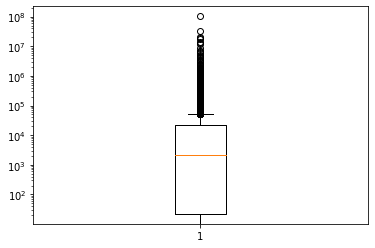

In [235]:
plt.boxplot(x.sum(axis=0))
plt.yscale('log')

C: Data is expected raw counts - needs normalisation

Make adata

In [236]:
genes=pd.read_table(path_ds+'mart_grch37_hs_genes.txt',index_col=0)

Make adata

In [237]:
adata=sc.AnnData(X=csr_matrix(x),obs=obs,
                 var=pd.DataFrame(index=x.columns))

In [238]:
# Edit var
adata.var['EID']=adata.var_names
adata.var_names=genes.loc[x.columns,'Gene name']

In [239]:
adata.var

,EID
Gene name,
LINC00362,ENSG00000229483
LINC00363,ENSG00000232849
SACS-AS1,ENSG00000229558
LINC00327,ENSG00000232977
LINC00352,ENSG00000227893
...,...
RP11-767C1.1,ENSG00000232746
PIP4K2A,ENSG00000150867
RP11-536I6.2,ENSG00000255021


In [240]:
adata

AnnData object with n_obs × n_vars = 638 × 26616
    obs: 'geo_accession', 'cell_type_original', 'sex', 'disease', 'age', 'ethnicity', 'BMI', 'donor', 'cell_type', 'medication', 'HbA1c'
    var: 'EID'

In [241]:
# Save orginal X
adata.layers['raw']=adata.X.copy()

In [242]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [243]:
adata

AnnData object with n_obs × n_vars = 638 × 26616
    obs: 'geo_accession', 'cell_type_original', 'sex', 'disease', 'age', 'ethnicity', 'BMI', 'donor', 'cell_type', 'medication', 'HbA1c'
    var: 'EID'
    uns: 'log1p'
    layers: 'raw'

In [244]:
for col in [c for c in adata.obs.columns if c!='geo_accession']:
    print(col)
    print(adata.obs[col].unique().tolist())

cell_type_original
['None/Other', 'Beta', 'Stellate', 'Ductal', 'Alpha', 'Acinar', 'Gamma/PP', 'Delta']
sex
['female', 'male']
disease
['T2D', 'healthy']
age
['55 y', '42 y', '22 y', '51 y', '53 y', '29 y', '30 y', '56 y']
ethnicity
['white', 'hispanic', 'african_american']
BMI
['29.8', '43', '32.95', '35.8', '22', '23', '55', '26.6']
donor
['ACIW009', 'ACJV399', 'ACCG268', 'ACCR015A', 'ACEK420A', 'ACEL337', 'ACHY057', 'ACIB065']
cell_type
['dropped', 'beta', 'stellate', 'ductal', 'alpha', 'acinar', 'gamma', 'delta']
medication
['no', 'yes']
HbA1c
[7.4, 6.5, 5.4, nan, 5.1, 5.2]


In [245]:
if SAVE:
    adata.write(path_ds_sub+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_original' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sex' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical

In [246]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds+'adata_filtered.h5ad')

(617, 26616)


## GSE81547

In [247]:
dataset='GSE81547'
path_ds=data_path+dataset+'/GEO/'

Metadata

In [248]:
obs=pd.read_table(path_ds+'GSE81547_series_matrix.txt',
                  skiprows=29,index_col=0)

In [249]:
obs

,21yr_male_cell1,21yr_male_cell2,21yr_male_cell3,21yr_male_cell4,21yr_male_cell5,21yr_male_cell6,21yr_male_cell7,21yr_male_cell8,21yr_male_cell9,21yr_male_cell10,...,22yr_male_cell2535,22yr_male_cell2536,22yr_male_cell2537,22yr_male_cell2538,22yr_male_cell2539,22yr_male_cell2540,22yr_male_cell2541,22yr_male_cell2542,22yr_male_cell2543,22yr_male_cell2544
!Sample_title,,,,,,,,,,,,,,,,,,,,,
!Sample_geo_accession,GSM2171880,GSM2171881,GSM2171882,GSM2171883,GSM2171884,GSM2171885,GSM2171886,GSM2171887,GSM2171888,GSM2171889,...,GSM2174416,GSM2174417,GSM2174418,GSM2174419,GSM2174420,GSM2174421,GSM2174422,GSM2174423,GSM2174424,GSM2174425
!Sample_status,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,...,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017,Public on Sep 28 2017
!Sample_submission_date,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,...,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016,May 20 2016
!Sample_last_update_date,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,...,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019,May 15 2019
!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
!Sample_source_name_ch1,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,...,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet,Pancreatic islet
!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
!Sample_characteristics_ch1,donor_age: 21,donor_age: 21,donor_age: 21,donor_age: 21,donor_age: 21,donor_age: 21,donor_age: 21,donor_age: 21,donor_age: 21,donor_age: 21,...,donor_age: 22,donor_age: 22,donor_age: 22,donor_age: 22,donor_age: 22,donor_age: 22,donor_age: 22,donor_age: 22,donor_age: 22,donor_age: 22


In [250]:
# Subset obs
obs=obs.T[['!Sample_geo_accession','!Sample_characteristics_ch1']]
obs.columns=['geo_accession','age','sex','cell_type_original']

Add donor info

In [251]:
# Add donor info
donor_df=pd.read_table(path_ds+'GSE81547_donors.txt',index_col=0)

In [252]:
donor_df

,age,sex,ethnicity,death_cause,BMI
donor,,,,,
DID_scRSq01,1 m,male,african_american,anoxia,13.71
DID_scRSq02,5 y,male,caucasian,auto_accident,17.60
DID_scRSq03,6 y,male,NaN,head_trauma,NaN
DID_scRSq04,21 y,male,caucasian,anoxia,28.40
DID_scRSq05,22 y,male,asian,head_trauma,24.80
DID_scRSq06,38 y,female,african_caucasian,stroke,29.50
DID_scRSq07,44 y,female,american,stroke,23.80
DID_scRSq08,54 y,male,caucasian,anoxia,27.29


In [253]:
# Parse obs
obs['age']=obs['age'].apply(lambda x: x.split(': ')[1])
obs['sex']=obs['sex'].str.replace('gender: ','')
obs['cell_type_original']=obs['cell_type_original'].str.replace('inferred_cell_type: ','')

In [254]:
# Match to donor based on metadata
for idx in obs.index:
    sex=obs.at[idx,'sex']
    age=obs.at[idx,'age']
    donors=donor_df.query('sex == @sex and age.str.split(' ').str[0] == @age', 
                          engine="python").index
    if donors.shape[0]!=1:
        print(obs.loc[idx,:],donors)
        raise ValueError('Could not match to single donor')
    else:
        obs.at[idx,'donor']=donors[0]

In [255]:
# Add donor metadata
for col in ['sex','age','ethnicity','BMI']:
    obs[col]=obs['donor'].map(donor_df[col].to_dict())

In [256]:
obs['cell_type_original'].value_counts(dropna=False)

alpha          998
acinar         411
ductal         389
beta           348
unsure         262
delta           83
mesenchymal     53
Name: cell_type_original, dtype: int64

In [257]:
obs['cell_type']=obs['cell_type_original'].replace(
    {'unsure':'unknown','mesenchymal':'mesenchyme'})
obs['cell_type'].value_counts(dropna=False)

alpha         998
acinar        411
ductal        389
beta          348
unknown       262
delta          83
mesenchyme     53
Name: cell_type, dtype: int64

In [258]:
# Change index for matching with x
obs['cell_name']=obs.index
obs.index=obs.geo_accession

In [259]:
# All donors where healthy
obs['disease']='healthy'

In [260]:
obs

,geo_accession,age,sex,cell_type_original,donor,ethnicity,BMI,cell_type,cell_name,disease
geo_accession,,,,,,,,,,
GSM2171880,GSM2171880,21 y,male,alpha,DID_scRSq04,caucasian,28.4,alpha,21yr_male_cell1,healthy
GSM2171881,GSM2171881,21 y,male,alpha,DID_scRSq04,caucasian,28.4,alpha,21yr_male_cell2,healthy
GSM2171882,GSM2171882,21 y,male,acinar,DID_scRSq04,caucasian,28.4,acinar,21yr_male_cell3,healthy
GSM2171883,GSM2171883,21 y,male,alpha,DID_scRSq04,caucasian,28.4,alpha,21yr_male_cell4,healthy
GSM2171884,GSM2171884,21 y,male,alpha,DID_scRSq04,caucasian,28.4,alpha,21yr_male_cell5,healthy
...,...,...,...,...,...,...,...,...,...,...
GSM2174421,GSM2174421,22 y,male,unsure,DID_scRSq05,asian,24.8,unknown,22yr_male_cell2540,healthy
GSM2174422,GSM2174422,22 y,male,beta,DID_scRSq05,asian,24.8,beta,22yr_male_cell2541,healthy
GSM2174423,GSM2174423,22 y,male,mesenchymal,DID_scRSq05,asian,24.8,mesenchyme,22yr_male_cell2542,healthy


In [261]:
obs.drop_duplicates('donor')

,geo_accession,age,sex,cell_type_original,donor,ethnicity,BMI,cell_type,cell_name,disease
geo_accession,,,,,,,,,,
GSM2171880,GSM2171880,21 y,male,alpha,DID_scRSq04,caucasian,28.40,alpha,21yr_male_cell1,healthy
GSM2172385,GSM2172385,38 y,female,acinar,DID_scRSq06,african_caucasian,29.50,acinar,38yr_female_cell506,healthy
GSM2172764,GSM2172764,1 m,male,beta,DID_scRSq01,african_american,13.71,beta,1yr_male_cell885,healthy
GSM2172916,GSM2172916,5 y,male,acinar,DID_scRSq02,caucasian,17.60,acinar,5yr_male_cell1037,healthy
GSM2172929,GSM2172929,44 y,female,alpha,DID_scRSq07,american,23.80,alpha,44yr_female_cell1050,healthy
GSM2173153,GSM2173153,6 y,male,alpha,DID_scRSq03,NaN,NaN,alpha,6yr_male_cell1274,healthy
GSM2173868,GSM2173868,54 y,male,alpha,DID_scRSq08,caucasian,27.29,alpha,54yr_male_cell1987,healthy
GSM2174140,GSM2174140,22 y,male,alpha,DID_scRSq05,asian,24.80,alpha,22yr_male_cell2259,healthy


Expression

In [262]:
# Functions for loading expression files
def read_fn(f):
    # Read ingle matrix file
    return pd.read_table(f,sep='\t',index_col=0,header=None)

def read_gz(fn,read_fn=read_fn):
    # Read gzipped file
    uncompressed_file_type = fn.split('.')[-2]
    with TemporaryDirectory() as tmpdir:
        tmppth = tmpdir + f"/decompressed.{uncompressed_file_type}"
        with gzip.open(fn, "rb") as input_f, open(tmppth, "wb") as output_f:
            shutil.copyfileobj(input_f, output_f)
        x = read_fn(tmppth)
    return x

In [263]:
remove_var=['tAKR', 'no_feature', 'ambiguous', 'too_low_aQual', 'not_aligned',
       'alignment_not_unique']
x=[]
for f in glob.glob(path_ds+'expression/*'):
    # Read, drop non-genes, rename to cell name
    x.append(read_gz(f
                   ).drop(remove_var).rename({1:f.split('/')[-1].split('_')[0]},axis=1))
x=pd.concat(x,axis=1)    

In [264]:
x

,GSM2173639,GSM2172616,GSM2172868,GSM2172105,GSM2171951,GSM2173331,GSM2174365,GSM2172413,GSM2174041,GSM2173380,...,GSM2172319,GSM2173701,GSM2172161,GSM2173318,GSM2172397,GSM2171961,GSM2172769,GSM2172932,GSM2174031,GSM2172260
0,,,,,,,,,,,,,,,,,,,,,
1/2-SBSRNA4,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,5,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,7,0,3,0
A1BG-AS1,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,2,0
A1CF,0,0,0,0,22,11,29,0,0,105,...,0,23,0,0,0,0,27,0,0,0
A2LD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11B,0,358,125,129,0,13,45,0,0,0,...,0,0,56,0,0,15,0,406,0,0
ZYX,0,0,150,0,0,4,0,92,0,94,...,98,43,0,0,426,0,0,0,0,69


Make adata

In [265]:
var=pd.DataFrame(index=x.T.columns)
var.index.name=None
adata=sc.AnnData(X=csr_matrix(x.T),obs=obs.reindex(x.columns),
                 var=var)

In [266]:
adata

AnnData object with n_obs × n_vars = 2544 × 23459
    obs: 'geo_accession', 'age', 'sex', 'cell_type_original', 'donor', 'ethnicity', 'BMI', 'cell_type', 'cell_name', 'disease'

In [267]:
# Save orginal X
adata.layers['raw']=adata.X.copy()

In [268]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [269]:
adata

AnnData object with n_obs × n_vars = 2544 × 23459
    obs: 'geo_accession', 'age', 'sex', 'cell_type_original', 'donor', 'ethnicity', 'BMI', 'cell_type', 'cell_name', 'disease'
    uns: 'log1p'
    layers: 'raw'

In [270]:
for col in [c for c in adata.obs.columns if c!='geo_accession' and c!='cell_name']:
    print(col)
    print(adata.obs[col].unique().tolist())

age
['5 y', '38 y', '21 y', '44 y', '22 y', '54 y', '6 y', '1 m']
sex
['male', 'female']
cell_type_original
['acinar', 'beta', 'unsure', 'alpha', 'ductal', 'delta', 'mesenchymal']
donor
['DID_scRSq02', 'DID_scRSq06', 'DID_scRSq04', 'DID_scRSq07', 'DID_scRSq05', 'DID_scRSq08', 'DID_scRSq03', 'DID_scRSq01']
ethnicity
['caucasian', 'african_caucasian', 'american', 'asian', nan, 'african_american']
BMI
[17.6, 29.5, 28.4, 23.8, 24.8, 27.29, nan, 13.71]
cell_type
['acinar', 'beta', 'unknown', 'alpha', 'ductal', 'delta', 'mesenchyme']
disease
['healthy']


In [271]:
if SAVE:
    adata.write(path_ds+'adata.h5ad')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sex' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_catego

In [272]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds+'adata_filtered.h5ad')

(2282, 23459)


## GSE114297 - no ct anno

## GSE198623
At the time of the analysis this dataset was not yet published (in-house data). The data is now availiable on GEO. In some of the notebooks this dataset is also called "Sophie's".

Requires just some cell column renaming

In [320]:
dataset='P21000'
path_ds=data_path+dataset+'/sophie/human/'

In [281]:
adata_original=sc.read(path_ds+'human_processed.h5ad')

In [275]:
adata_original

AnnData object with n_obs × n_vars = 26474 × 32738
    obs: 'sample', 'louvain_anno_broad', 'louvain_anno_fine', 'id', 'BMI', 'HbA1c', 'insulin_content', 'glucose_SI', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'organism_ontolology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'n_counts', 'mt_frac', 'size_factors'
    var: 'feature_is_filtered', 'feature_biotype'
    uns: 'X_normalization', 'batch_condition', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

In [292]:
# Modify adata to match others
adata=adata_original.copy()
adata.obs.drop(adata.obs.columns,axis=1,inplace=True)
adata.layers['raw']=adata.raw.X.copy()
adata.layers['normalised_original']=adata.X.copy()
adata.X=adata.raw.X
del adata.raw
del adata.obsm['X_pca']
del adata.obsm['X_umap']
del adata.uns

In [296]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [327]:
# Modify obs
adata.obs['donor']=adata_original.obs['id']
adata.obs['age']=adata_original.obs['sample'].apply(lambda x:x.split('_')[1]+ ' y')
adata.obs['sex']=adata_original.obs['sex_ontology_term_id'].map(
    {'PATO_0000383':'female', 'PATO_0000384':'male'})
adata.obs['BMI']=adata_original.obs['BMI'].astype(float)
adata.obs['HbA1c']=adata_original.obs['HbA1c'].astype(float)
adata.obs['cell_type_original']=adata_original.obs['louvain_anno_broad']
adata.obs['cell_type']=adata_original.obs['louvain_anno_broad'].replace({'PP':'gamma'})
adata.obs['cell_subtype_original']=adata_original.obs['louvain_anno_fine']
adata.obs['disease']='healthy'

In [313]:
adata.obs['cell_type'].value_counts(dropna=False)

beta     11923
alpha    11541
delta     2889
gamma      121
Name: cell_type, dtype: int64

In [363]:
# Map var symbols, use EID if can not map symbol
gene_map=pd.read_table(path_genes+'HGNC_export_104HS_EnsemblID.txt',index_col=1)
adata.var['EID']=adata_original.var.index
eids=set(gene_map.index)
symbols=[]
for g in adata.var_names:
    if g in eids:
        s=gene_map.at[g,'Approved symbol']
        if isinstance(s,str):
            symbols.append(s)
        else:
            symbols.append(g)
    else:
        symbols.append(g)
adata.var_names=symbols

In [365]:
(adata.var.index==adata.var.EID).sum()

9165

In [366]:
adata

AnnData object with n_obs × n_vars = 26474 × 32738
    obs: 'donor', 'age', 'sex', 'BMI', 'HbA1c', 'cell_type_original', 'cell_type', 'cell_subtype_original', 'disease'
    var: 'feature_is_filtered', 'feature_biotype', 'EID'
    uns: 'log1p'
    layers: 'raw', 'normalised_original'

In [328]:
for col in [c for c in adata.obs.columns if c!='geo_accession' and c!='cell_name']:
    print(col)
    print(adata.obs[col].unique().tolist())

donor
['R229', 'R239', 'R237', 'R245', 'R266']
age
['22 y', '24 y', '61 y', '63 y', '74 y']
sex
['female', 'male']
BMI
[23.0, 22.0, 19.6, 22.3, 29.2]
HbA1c
[5.3, 5.5, 5.9, 5.6, 6.0]
cell_type_original
['alpha', 'delta', 'beta', 'PP']
cell_type
['alpha', 'delta', 'beta', 'gamma']
cell_subtype_original
['alpha_stress II', 'delta', 'alpha_mature', 'beta_mature', 'alpha_immature', 'beta_immature', 'beta_stress II', 'beta_stress I', 'beta_MHC/autoantigen', 'alpha_MHC II', 'beta_mtDNA deficient', 'PP']
disease
['healthy']


In [367]:
if SAVE:
    adata.write(path_ds+'adata_filtered.h5ad') # Already no NA cells

## GSE148073 - 10x v2/v3

In [7]:
dataset='GSE148073'
path_ds=data_path+dataset+'/GEO/'

In [6]:
adata_original=sc.read(path_ds+'local.h5ad')

In [7]:
adata_original

AnnData object with n_obs × n_vars = 69645 × 26163
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'disease_state', 'cell_label', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'ethnicity_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference'
    uns: 'X_normalization', 'layer_descriptions', 'publication_doi', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'
    layers: 'scale.data'

In [8]:
adata_original.raw

In [9]:
# Modify adata to match others
adata=adata_original.copy()
adata.obs.drop(adata.obs.columns,axis=1,inplace=True)
adata.var.drop(adata.var.columns,axis=1,inplace=True)
adata.layers['raw']=adata.raw.X.copy()
adata.layers['normalised_original']=adata.X.copy()
adata.X=adata.raw.X
del adata.raw
del adata.obsm['X_pca']
del adata.obsm['X_umap']
del adata.uns
del adata.layers['scale.data']

In [10]:
# Log normalise
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
adata_original.obs[['disease_state', 'cell_label', 'cell_type',  'disease',  ]]

,disease_state,cell_label,cell_type,disease
AAACCTGAGGTGTGGT-1,Control,alpha,pancreatic A cell,normal
AAACCTGCACGCCAGT-1,Control,beta_major,type B pancreatic cell,normal
AAACCTGCAGTCGATT-1,Control,alpha,pancreatic A cell,normal
AAACCTGTCACATACG-1,Control,endothelial,endothelial cell,normal
AAACCTGTCACCCTCA-1,Control,alpha,pancreatic A cell,normal
...,...,...,...,...
TTTGGTTCATACCATG-25,T1D,acinar,pancreatic acinar cell,type 1 diabetes mellitus
TTTGGTTCATCCGGGT-25,T1D,acinar,pancreatic acinar cell,type 1 diabetes mellitus
TTTGTCAAGCCGTCGT-25,T1D,acinar,pancreatic acinar cell,type 1 diabetes mellitus
TTTGTCAGTAAGGGAA-25,T1D,endothelial,endothelial cell,type 1 diabetes mellitus


In [12]:
pd.crosstab(adata_original.obs.disease_state,adata_original.obs.disease)

disease,normal,type 1 diabetes mellitus
disease_state,,
AAB,20651,0
Control,26594,0
T1D,0,22400


In [13]:
pd.crosstab(adata_original.obs.cell_label,adata_original.obs.cell_type)

cell_type,PP cell,endothelial cell,native cell,pancreatic A cell,pancreatic D cell,pancreatic acinar cell,pancreatic ductal cell,pancreatic epsilon cell,pancreatic stellate cell,type B pancreatic cell
cell_label,,,,,,,,,,
acinar,0,0,0,0,0,19076,0,0,0,0
acinar_minor_mhcclassII,0,0,0,0,0,4140,0,0,0,0
alpha,0,0,0,11589,0,0,0,0,0,0
beta_major,0,0,0,0,0,0,0,0,0,9796
beta_minor,0,0,0,0,0,0,0,0,0,1502
delta,0,0,0,0,1410,0,0,0,0,0
duct_acinar_related,0,0,0,0,0,0,5978,0,0,0
duct_major,0,0,0,0,0,0,5946,0,0,0
endothelial,0,2658,0,0,0,0,0,0,0,0


In [14]:
adata.obs['cell_type_original']=adata_original.obs['cell_label']
adata.obs['cell_type']=adata.obs['cell_type_original'].replace({
    'acinar_minor_mhcclassII':'acinar','beta_major':'beta','beta_minor':'beta',
    'duct_acinar_related':'ductal','duct_major':'ductal','hybrid':'unknown',
    'immune_stellates':'immune_stellate','pp':'gamma','stellates':'stellate'})
adata.obs['disease']=adata_original.obs.disease_state.replace({'Control':'healthy'})

In [49]:
adata.obs['cell_type'].value_counts()

acinar             23216
ductal             11924
alpha              11589
beta               11298
unknown             3593
endothelial         2658
stellate            2163
delta               1410
immune_stellate      832
gamma                761
epsilon              201
Name: cell_type, dtype: int64

In [95]:
# Load donor info
donor_df=pd.read_excel(path_ds+'42255_2022_531_MOESM3_ESM.xlsx',
                       header=[0,1],skiprows=[0,44,45,46,47,48],
                       # read as str for below parsing
                      dtype='str')

In [96]:
# Merge rows as data of some patients spans multiple rows
temp=[]
curr_donor=-1
for row_idx,data in donor_df.iterrows():
    donor=data[('Identifier','Unnamed: 0_level_1')]
    if isinstance(donor,str):
        temp.append(data.to_dict())
        curr_donor+=1
    else:
        for col,val in data.iteritems():
            if isinstance(val,str):
                temp[curr_donor][col]=str(temp[curr_donor][col])+' '+str(val)
donor_df=pd.DataFrame(temp)
del temp

In [79]:
donor_df

,"(Identifier, Unnamed: 0_level_1)","(HPAP, Identifier)","(Sex/, Age)","(Ancestry, Unnamed: 3_level_1)","(BMI, Unnamed: 4_level_1)","(Medical History, Unnamed: 5_level_1)","(Anti-Islet Autoantibody, GAD)","(Anti-Islet Autoantibody, IA-2)","(Anti-Islet Autoantibody, mIAA)","(Anti-Islet Autoantibody, ZnT8)","(HbA1c, (C-Peptide))","(Cold Ischemia Time (hr), Unnamed: 11_level_1)","(Total, Islet Yield (IEQ))","(EBV status, IgG / IgM)"
0,Control #1,HPAP022,F/39yo,Caucasian,34.7 (Obese),No HX DIAB,Neg.,Neg.,Neg.,Neg.,4.7 (9.35),08:33:00,500000,Negative / Negative
1,Control #2,HPAP026,M/24yo,Caucasian,20.6 (Normal),No HX DIAB,GAD+(Neg.)†,Neg.,Neg.,Neg.,4.9 (0.25),16:27:00 (DCD WIT 22 mins),238452,Positive / Negative
2,Control #3,HPAP034,M/13yo,Caucasian,18.7 (Between 50th-75th Percentile; Normal),No HX DIAB,Neg.,Neg.,Neg.,Neg.,5.2 (12.7),11:31:00,284790,Positive / Negative
3,Control #4,HPAP035,M/35yo,Caucasian,26.9 (Overweight),No HX DIAB,Neg.,Neg.,Neg.,Neg.,5.2 (15.9),12:55:00,303431,Negative / Negative
4,Control #5,HPAP036,F/23yo,Caucasian,16.0 (Underweight),No HX DIAB,Neg.,Neg.,Neg.,Neg.,5.2 (1.12),17:27:00,258650,Positive / Negative
5,Control #6,HPAP037,F/35yo,Caucasian,21.9 (Normal),No HX DIAB,Neg.,Neg.,Neg.,Neg.,5.3 (4.75),12:02:00,109866,Positive / Negative
6,Control #7,HPAP039,F/5yo,Caucasian,16.3 (Between 75th-85th percentile; Normal),No HX DIAB,Neg.,Neg.,Neg.,Neg.,6.8 (1.88),22:43:00,151858,Negative / Not measured
7,Control #8,HPAP040,M/35yo,Caucasian,23.98 (Normal),No HX DIAB,Neg.,Neg.,Neg.,Neg.,5.4 (7.01),11:32:00,596235,Positive / Negative
8,Control #9,HPAP042,M/13month,Caucasian,BMI: 17.9 Bodyweight: 9.4 kg (weight percentil...,No HX DIAB,Neg.,Neg.,Neg.,Neg.,5.2-5.6* (2.72),16:59:00 (DCD WIT 17 mins),59592,Negative / Negative
9,Control #10,HPAP044,F/3yo,Caucasian,12.0 (Below 3rd Percentile; Underweight),No HX DIAB,Neg.,Neg.,Neg.,Neg.,5.3 (8.16),16:42:00,74940,Positive / Negative


In [97]:
# Parse donor df
donor_df.index=donor_df[('HPAP', 'Identifier')]
donor_df.rename({('Sex/', 'Age'):'sex_age',
                 ('Ancestry', 'Unnamed: 3_level_1'):'ethnicity',
                 ('BMI', 'Unnamed: 4_level_1'):"BMI",
                 ('Medical History', 'Unnamed: 5_level_1'):'diabetes',
                 ('HbA1c', '(C-Peptide)'):'HbA1c'
                },axis=1,inplace=True)
donor_df['sex']=donor_df['sex_age'].apply(lambda x: x.split('/')[0]).map(
    {'F':'female','M':'male'})
donor_df['age']=donor_df['sex_age'].apply(
    lambda x: x.split('/')[1].replace('yo',' y').replace('month',' m'))
donor_df['ethnicity']=donor_df['ethnicity'].str.lower()
donor_df['BMI']=donor_df['BMI'].apply(lambda x: x.split()[0] 
                                      if not x.split()[0].startswith("BMI") else x.split()[1])
donor_df['years_diagnosis']=donor_df['diabetes'].apply(
    lambda x:np.nan if 'yrs duration' not in x else x.split('(')[1].split()[0])
donor_df['HbA1c']=donor_df['HbA1c'].apply(lambda x: x.split()[0].replace('*','') 
                                          if  x.split()[0]!='Not' else np.nan)
donor_df=donor_df[['sex','age','ethnicity','BMI','years_diagnosis','HbA1c']]

In [87]:
donor_df

,sex,age,ethnicity,BMI,years_diagnosis,HbA1c
"(HPAP, Identifier)",,,,,,
HPAP022,female,39 y,caucasian,34.7,NaN,4.7
HPAP026,male,24 y,caucasian,20.6,NaN,4.9
HPAP034,male,13 y,caucasian,18.7,NaN,5.2
HPAP035,male,35 y,caucasian,26.9,NaN,5.2
HPAP036,female,23 y,caucasian,16.0,NaN,5.2
HPAP037,female,35 y,caucasian,21.9,NaN,5.3
HPAP039,female,5 y,caucasian,16.3,NaN,6.8
HPAP040,male,35 y,caucasian,23.98,NaN,5.4
HPAP042,male,13 m,caucasian,17.9,NaN,5.2-5.6


In [53]:
# Load data with donor info
ro.globalenv['path_ds']=path_ds
# Load Seurat rds and extract metadata
obs1=ro.r("readRDS(paste0(path_ds,'fasolino_et_al.rds'))[[]]")

In [61]:
obs1.iloc[0,:].to_dict()

{'nCount_RNA': 15507.0,
 'nFeature_RNA': 2971,
 'percent.mt': 5.429805894112336,
 'RNA_snn_res.1.2': '7',
 'seurat_clusters': '7',
 'disease_state': 'Control',
 'cell_label': 'alpha',
 'assay_ontology_term_id': 'EFO:0008995',
 'assay': '10X sequencing',
 'ethnicity_ontology_term_id': '',
 'ethnicity': 'unknown',
 'sex': 'mixed',
 'disease_ontology_term_id': 'PATO:0000461',
 'disease': 'normal',
 'tissue_ontology_term_id': 'UBERON:0000006',
 'tissue': 'islet of Langerhans',
 'cell_type_ontology_term_id': 'CL:0000171',
 'cell_type': 'pancreatic A cell',
 'development_stage_ontology_term_id': 'HsapDv:0000087',
 'development_stage': 'human adult stage',
 'sample_id': 'ControlA',
 'hpap_id': 'HPAP022',
 'sample_id_num': 'Control1'}

C: only donor col is useful from here

In [59]:
print('Adata and Seurat obs names match:',(adata.obs_names==obs1.index).all())

Adata and Seurat obs names match: True


In [62]:
# Add donor to obs
adata.obs['donor']=obs1['hpap_id']

In [88]:
# Add donor info to obs
for col in donor_df.columns:
    adata.obs[col]=adata.obs['donor'].map(donor_df[col].to_dict())

In [101]:
adata.obs['organism']='human'

In [102]:
adata.obs.drop_duplicates('donor')

,cell_type_original,cell_type,disease,donor,sex,age,ethnicity,BMI,years_diagnosis,HbA1c,organism
AAACCTGAGGTGTGGT-1,alpha,alpha,healthy,HPAP022,female,39 y,caucasian,34.7,NaN,4.7,human
AAACCTGCACCTTGTC-2,pp,gamma,healthy,HPAP026,male,24 y,caucasian,20.6,NaN,4.9,human
AAACGGGAGTAGCGGT-3,beta_major,beta,healthy,HPAP034,male,13 y,caucasian,18.7,NaN,5.2,human
AAACCTGCAGCTGTAT-4,alpha,alpha,healthy,HPAP035,male,35 y,caucasian,26.9,NaN,5.2,human
AAACCTGAGACGCAAC-5,beta_major,beta,healthy,HPAP036,female,23 y,caucasian,16.0,NaN,5.2,human
AAACCTGCACCAGATT-6,beta_major,beta,healthy,HPAP037,female,35 y,caucasian,21.9,NaN,5.3,human
AAACCCAAGGACATCG-7,acinar,acinar,healthy,HPAP039,female,5 y,caucasian,16.3,NaN,6.8,human
AAACCCAAGTAGTCAA-8,alpha,alpha,healthy,HPAP040,male,35 y,caucasian,23.98,NaN,5.4,human
AAACCCACAACCTAAC-9,duct_acinar_related,ductal,healthy,HPAP042,male,13 m,caucasian,17.9,NaN,5.2-5.6,human
AAACGAACAAGCGCTC-10,acinar,acinar,healthy,HPAP044,female,3 y,caucasian,12.0,NaN,5.3,human


In [108]:
# Map var symbols, use EID if can not map symbol
gene_map=pd.read_table(path_genes+'HGNC_export_104HS_EnsemblID.txt',index_col=1)
adata.var['EID']=adata_original.var.index
eids=set(gene_map.index)
symbols=[]
for g in adata.var_names:
    if g in eids:
        s=gene_map.at[g,'Approved symbol']
        if isinstance(s,str):
            symbols.append(s)
        else:
            symbols.append(g)
    else:
        symbols.append(g)
adata.var_names=symbols

In [109]:
(adata.var.index==adata.var.EID).sum()

4966

In [110]:
adata

AnnData object with n_obs × n_vars = 69645 × 26163
    obs: 'cell_type_original', 'cell_type', 'disease', 'donor', 'sex', 'age', 'ethnicity', 'BMI', 'years_diagnosis', 'HbA1c', 'organism'
    var: 'EID'
    uns: 'log1p'
    layers: 'raw', 'normalised_original'

In [104]:
for col in [c for c in adata.obs.columns if c!='geo_accession' and c!='cell_name']:
    print(col)
    print(adata.obs[col].unique().tolist())

cell_type_original
['alpha', 'beta_major', 'endothelial', 'delta', 'stellates', 'beta_minor', 'duct_major', 'immune_stellates', 'acinar_minor_mhcclassII', 'hybrid', 'acinar', 'epsilon', 'duct_acinar_related', 'pp']
cell_type
['alpha', 'beta', 'endothelial', 'delta', 'stellate', 'ductal', 'immune_stellate', 'acinar', 'unknown', 'epsilon', 'gamma']
disease
['healthy', 'AAB', 'T1D']
donor
['HPAP022', 'HPAP026', 'HPAP034', 'HPAP035', 'HPAP036', 'HPAP037', 'HPAP039', 'HPAP040', 'HPAP042', 'HPAP044', 'HPAP047', 'HPAP019', 'HPAP024', 'HPAP029', 'HPAP038', 'HPAP043', 'HPAP045', 'HPAP049', 'HPAP050', 'HPAP020', 'HPAP021', 'HPAP023', 'HPAP028', 'HPAP032']
sex
['female', 'male']
age
['39 y', '24 y', '13 y', '35 y', '23 y', '5 y', '13 m', '3 y', '8 y', '22 y', '18 y', '15 y', '27 y', '29 y', '21 y', '14 y', '17 y', '4 y', '10 y']
ethnicity
['caucasian', 'hispanic']
BMI
['34.7', '20.6', '18.7', '26.9', '16.0', '21.9', '16.3', '23.98', '17.9', '12.0', '16.82', '29.8', '24.3', '28.6', '18.34', '24.07

In [111]:
if SAVE:
    adata.write(path_ds+'adata.h5ad')

In [112]:
# Subset to annotated cells
adata_sub=adata[~adata.obs.cell_type.isin(['dropped','unknown']),:]
print(adata_sub.shape)
if SAVE:
    adata_sub.write(path_ds+'adata_filtered.h5ad')

(66052, 26163)


Prepare per-sample scran normalisation (on filtered cells only)

In [8]:
# Load data
adata=sc.read(path_ds+'adata_filtered.h5ad')

In [10]:
# Use raw
adata.X=adata.layers['raw']

In [16]:
for sample, idx_sample in adata.obs.groupby('donor').groups.items():
    # Subset data
    adata_sub=adata[idx_sample,:].copy()
    print('Normalising:',sample,adata_sub.shape)
    # Faster on sparse matrices
    if not sparse.issparse(adata_sub.X): 
        adata_sub.X = sparse.csr_matrix(adata_sub.X)
    # Sort indices is necesary for conversion to R object 
    adata_sub.X.sort_indices()
    
    # Prepare clusters for scran
    adata_sub_pp=adata_sub.copy()
    sc.pp.normalize_total(adata_sub_pp, target_sum=1e6, exclude_highly_expressed=True)
    sc.pp.log1p(adata_sub_pp)
    sc.pp.pca(adata_sub_pp, n_comps=15)
    sc.pp.neighbors(adata_sub_pp)
    sc.tl.louvain(adata_sub_pp, key_added='groups', resolution=1)
    
    # Normalise
    ro.globalenv['data_mat'] = adata_sub.X.T.todense()
    ro.globalenv['input_groups'] = adata_sub_pp.obs['groups']
    try:
        size_factors = ro.r(f'calculateSumFactors(data_mat, clusters = input_groups, min.mean = 0.1, BPPARAM=MulticoreParam(workers = 16))')
    except:
        # Sometimes the above does not work so change parameter
        size_factors = ro.r(f'calculateSumFactors(data_mat, clusters = input_groups, min.mean = 0.2, BPPARAM=MulticoreParam(workers = 16))')
    adata.obs.loc[adata_sub.obs.index,'size_factors_sample'] = size_factors

del adata_sub
del adata_sub_pp

Normalising: HPAP019 (3786, 26163)
Normalising: HPAP020 (7776, 26163)
Normalising: HPAP021 (4537, 26163)
Normalising: HPAP022 (3550, 26163)
Normalising: HPAP023 (322, 26163)
Normalising: HPAP024 (1815, 26163)
Normalising: HPAP026 (449, 26163)
Normalising: HPAP028 (6466, 26163)
Normalising: HPAP029 (742, 26163)
Normalising: HPAP032 (2346, 26163)
Normalising: HPAP034 (349, 26163)
Normalising: HPAP035 (1885, 26163)
Normalising: HPAP036 (1885, 26163)
Normalising: HPAP037 (3724, 26163)
Normalising: HPAP038 (2269, 26163)
Normalising: HPAP039 (4052, 26163)
Normalising: HPAP040 (2127, 26163)
Normalising: HPAP042 (3086, 26163)
Normalising: HPAP043 (1648, 26163)
Normalising: HPAP044 (2720, 26163)
Normalising: HPAP045 (2984, 26163)
Normalising: HPAP047 (2370, 26163)
Normalising: HPAP049 (2926, 26163)
Normalising: HPAP050 (2238, 26163)


In [25]:
# Save parse anno and colors
if SAVE:
    h.update_adata(
            adata_new=adata, path=path_ds+'adata_filtered.h5ad',
            io_copy=False,
            add=[('obs',True,'size_factors_sample','size_factors_sample')],
        rm=None)